   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.2 MB/s eta 0:00:00
Device: cuda


100%|██████████| 4.17M/4.17M [00:06<00:00, 630kB/s]


Train/Val/Test: 4708 524 624
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


Epoch 1/2 | train loss 0.1411 acc 0.948 auc 0.985 | val loss 0.1128 acc 0.954 auc 0.993
Epoch 2/2 | train loss 0.0616 acc 0.978 auc 0.997 | val loss 0.0784 acc 0.964 auc 0.998
Loaded best val AUROC: 0.9975055456161499

=== Condition: clean ===


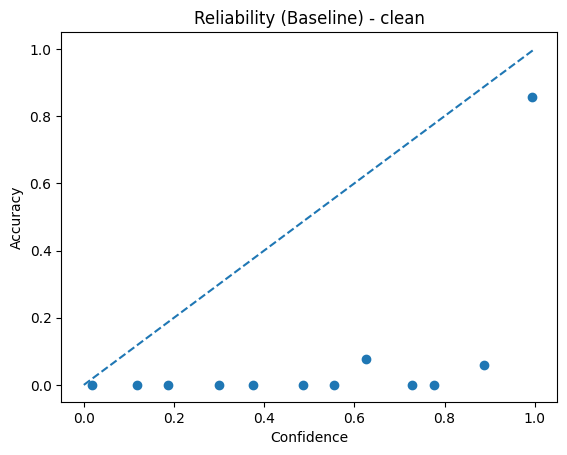

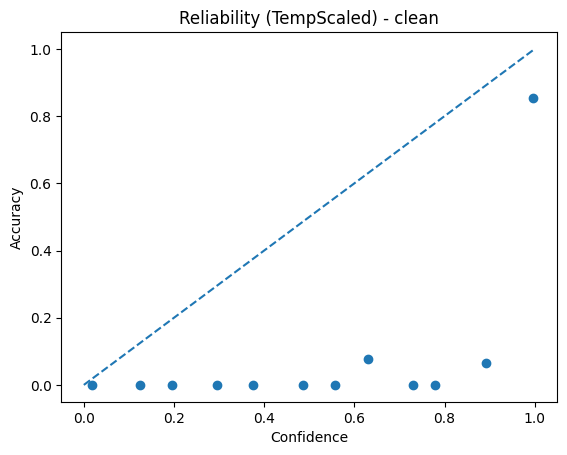


=== Condition: lowres_x4 ===

=== Condition: noise_s0.08 ===

=== Condition: jpeg_q30 ===

=== Condition: combined ===


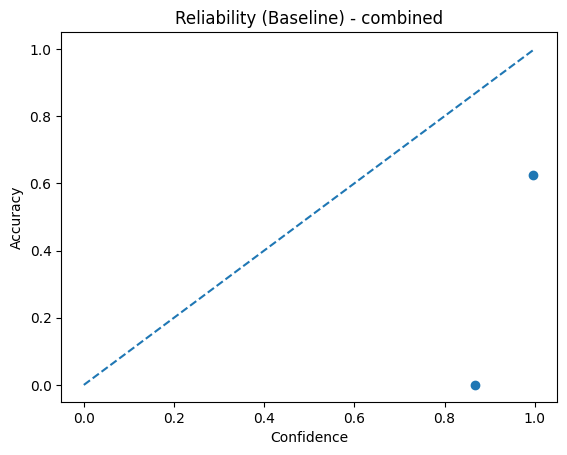

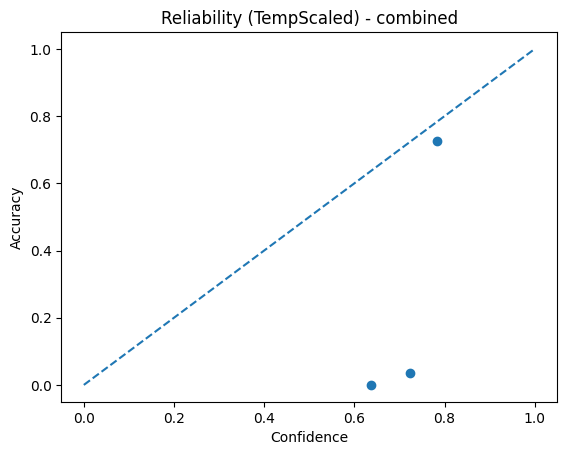


===== Summary Table =====


,condition,baseline_acc,baseline_auroc,baseline_ece,temp,tempscaled_acc,tempscaled_auroc,tempscaled_ece,mc_entropy_mean,mc_entropy_mean_incorrect
0,clean,0.801282,0.953682,0.187790,0.962948,0.801282,0.953687,0.188263,0.116937,0.305408
4,combined,0.625000,0.868343,0.370877,4.703331,0.625000,0.885273,0.187907,0.027213,0.044547
3,jpeg_q30,0.780449,0.954032,0.212181,0.968564,0.780449,0.954032,0.212775,0.122685,0.276693
1,lowres_x4,0.766026,0.946384,0.227860,1.183146,0.766026,0.946384,0.224558,0.117216,0.266223
2,noise_s0.08,0.625000,0.868798,0.371557,4.984554,0.625000,0.878079,0.138044,0.023938,0.033895



Saved CSV: /content/miccai2026_poc_results/metrics_summary.csv


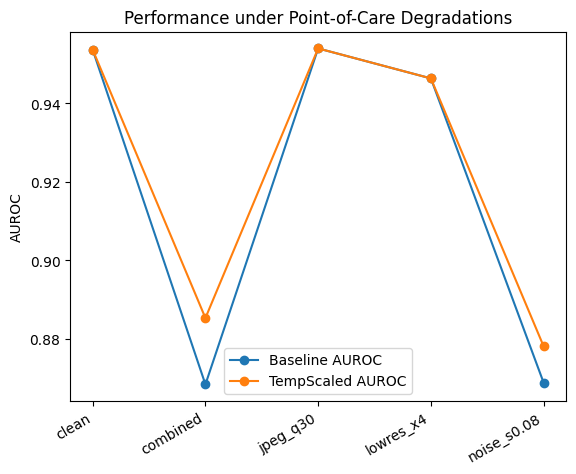

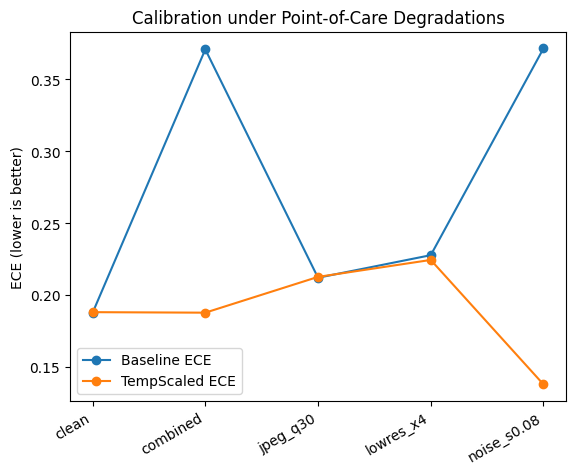

Saved JSON: /content/miccai2026_poc_results/metrics_summary.json

✅ Done. Outputs in: /content/miccai2026_poc_results/
Files: ['metrics_summary.json', 'reliability_tempscaled_clean.png', 'metrics_summary.csv', 'auroc_across_conditions.png', 'reliability_baseline_combined.png', 'reliability_tempscaled_combined.png', 'ece_across_conditions.png', 'reliability_baseline_clean.png']


In [ ]:
# ====== MICCAI 2026 (IDEA1) One-Cell Colab Pipeline ======
# Goal: End-to-end demo for "Trustworthy Point-of-Care Imaging under Resource Constraints"
# What you get after running this single cell:
# 1) Train a lightweight CXR classifier on MedMNIST (PneumoniaMNIST)
# 2) Simulate point-of-care degradations (low-res, noise, compression)
# 3) Evaluate performance + calibration (AUROC/ACC + ECE)
# 4) Apply post-hoc Temperature Scaling (no retraining) to improve calibration
# 5) Do MC-Dropout uncertainty inference and report uncertainty stats
# 6) Save results: CSV + reliability plots in /content

import os, math, random, time, json, warnings
warnings.filterwarnings("ignore")

# ---- (0) Install deps
!pip -q install medmnist torchmetrics tqdm pillow matplotlib pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import io

from torchmetrics.classification import BinaryAUROC, BinaryAccuracy
from torchmetrics.classification import BinaryCalibrationError

# ---- (1) Repro
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- (2) Load dataset: MedMNIST PneumoniaMNIST (binary, small, downloads automatically)
import medmnist
from medmnist import PneumoniaMNIST
from torchvision import transforms
from torchvision.models import resnet18

# MedMNIST images are 28x28 (grayscale). We'll upscale to 224 for ResNet18.
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),   # 1ch -> 3ch
    transforms.Resize((224,224)),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Resize((224,224)),
])

train_set = PneumoniaMNIST(split="train", transform=train_tf, download=True)
val_set   = PneumoniaMNIST(split="val",   transform=test_tf,  download=True)
test_set  = PneumoniaMNIST(split="test",  transform=test_tf,  download=True)

print("Train/Val/Test:", len(train_set), len(val_set), len(test_set))

BATCH = 64
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# ---- (3) Model: ResNet18 + dropout head (for MC-dropout uncertainty)
model = resnet18(weights="DEFAULT")
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.35),
    nn.Linear(in_features, 1)  # binary logit
)
model = model.to(device)

# ---- (4) Train quick (few epochs)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

def run_epoch(loader, train=True):
    model.train(train)
    auroc = BinaryAUROC().to(device)
    acc   = BinaryAccuracy().to(device)
    loss_meter = 0.0
    n = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).float().view(-1)
        logits = model(x).view(-1)
        loss = criterion(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            auroc.update(probs, y.int())
            acc.update(probs, y.int())
            bs = x.size(0)
            loss_meter += loss.item() * bs
            n += bs
    return loss_meter/n, float(acc.compute().cpu()), float(auroc.compute().cpu())

EPOCHS = 2  # keep it fast; raise to 5-10 for stronger results
best_val = -1
best_state = None

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_auc = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_auc = run_epoch(val_loader, train=False)
    print(f"Epoch {ep}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.3f} auc {tr_auc:.3f} "
          f"| val loss {va_loss:.4f} acc {va_acc:.3f} auc {va_auc:.3f}")
    if va_auc > best_val:
        best_val = va_auc
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

model.load_state_dict(best_state)
model.eval()
print("Loaded best val AUROC:", best_val)

# ---- (5) Degradation functions (simulate point-of-care conditions)
# We'll degrade tensors (0..1) on-the-fly, keeping shapes consistent.
def degrade_lowres(x, factor=4):
    # downsample then upsample
    h, w = x.shape[-2], x.shape[-1]
    nh, nw = h//factor, w//factor
    x_small = F.interpolate(x, size=(nh,nw), mode="bilinear", align_corners=False)
    x_back  = F.interpolate(x_small, size=(h,w), mode="bilinear", align_corners=False)
    return x_back

def degrade_noise(x, sigma=0.08):
    return torch.clamp(x + sigma*torch.randn_like(x), 0, 1)

def degrade_jpeg(x, quality=30):
    # per-image JPEG compress via PIL; slower but ok for small dataset demo
    xs = []
    x_cpu = x.detach().cpu()
    for img in x_cpu:
        # img: CxHxW in [0,1]
        arr = (img.permute(1,2,0).numpy()*255).astype(np.uint8)
        pil = Image.fromarray(arr)
        buf = io.BytesIO()
        pil.save(buf, format="JPEG", quality=int(quality))
        buf.seek(0)
        pil2 = Image.open(buf).convert("RGB")
        arr2 = np.array(pil2).astype(np.float32)/255.0
        t = torch.from_numpy(arr2).permute(2,0,1)
        xs.append(t)
    return torch.stack(xs, dim=0).to(x.device)

DEGRADES = {
    "clean": lambda x: x,
    "lowres_x4": lambda x: degrade_lowres(x, factor=4),
    "noise_s0.08": lambda x: degrade_noise(x, sigma=0.08),
    "jpeg_q30": lambda x: degrade_jpeg(x, quality=30),
    "combined": lambda x: degrade_noise(degrade_lowres(degrade_jpeg(x, quality=35), factor=4), sigma=0.06),
}

# ---- (6) Metrics helpers (ACC/AUROC + ECE)
ece_metric = BinaryCalibrationError(n_bins=15, norm="l1").to(device)

@torch.no_grad()
def predict_probs(loader, degrade_fn):
    all_probs, all_y = [], []
    model.eval()
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).int().view(-1)
        x = degrade_fn(x)
        logits = model(x).view(-1)
        probs = torch.sigmoid(logits)
        all_probs.append(probs.detach().cpu())
        all_y.append(y.detach().cpu())
    return torch.cat(all_probs), torch.cat(all_y)

@torch.no_grad()
def eval_metrics(probs, y_true):
    # probs, y_true are CPU tensors
    probs_d = probs.to(device)
    y_d = y_true.to(device).int()
    acc = BinaryAccuracy().to(device)(probs_d, y_d).item()
    auc = BinaryAUROC().to(device)(probs_d, y_d).item()
    ece = ece_metric(probs_d, y_d).item()
    return acc, auc, ece

# ---- (7) Temperature scaling (post-hoc calibration, no retraining)
class TemperatureScaler(nn.Module):
    def __init__(self, init_temp=1.0):
        super().__init__()
        self.log_t = nn.Parameter(torch.tensor([math.log(init_temp)], dtype=torch.float32))
    def forward(self, logits):
        t = torch.exp(self.log_t).clamp(1e-3, 100.0)
        return logits / t

def fit_temperature(val_loader, degrade_fn):
    scaler = TemperatureScaler(init_temp=1.5).to(device)
    optimizer = torch.optim.LBFGS(scaler.parameters(), lr=0.2, max_iter=50)

    # collect logits + labels on val
    logits_list, y_list = [], []
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).float().view(-1)
            x = degrade_fn(x)
            logits = model(x).view(-1)
            logits_list.append(logits)
            y_list.append(y)
    logits_all = torch.cat(logits_list)
    y_all = torch.cat(y_list)

    def closure():
        optimizer.zero_grad()
        scaled = scaler(logits_all)
        loss = F.binary_cross_entropy_with_logits(scaled, y_all)
        loss.backward()
        return loss

    optimizer.step(closure)
    t = float(torch.exp(scaler.log_t).detach().cpu())
    return scaler, t

@torch.no_grad()
def apply_scaler_probs(loader, degrade_fn, scaler):
    all_probs, all_y = [], []
    model.eval()
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).int().view(-1)
        x = degrade_fn(x)
        logits = model(x).view(-1)
        logits = scaler(logits)
        probs = torch.sigmoid(logits)
        all_probs.append(probs.detach().cpu())
        all_y.append(y.detach().cpu())
    return torch.cat(all_probs), torch.cat(all_y)

# ---- (8) MC Dropout uncertainty (predictive entropy)
def enable_dropout(m):
    for mod in m.modules():
        if isinstance(mod, nn.Dropout):
            mod.train()

@torch.no_grad()
def mc_dropout_probs(loader, degrade_fn, T=15):
    model.eval()
    enable_dropout(model)  # only dropout layers stochastic
    all_mean, all_ent, all_y = [], [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).int().view(-1)
        x = degrade_fn(x)
        probs_T = []
        for _ in range(T):
            logits = model(x).view(-1)
            probs_T.append(torch.sigmoid(logits))
        probs_T = torch.stack(probs_T, dim=0)  # T x B
        mean_p = probs_T.mean(dim=0)           # B
        # predictive entropy for Bernoulli
        eps = 1e-6
        ent = -(mean_p*torch.log(mean_p+eps) + (1-mean_p)*torch.log(1-mean_p+eps))
        all_mean.append(mean_p.detach().cpu())
        all_ent.append(ent.detach().cpu())
        all_y.append(y.detach().cpu())
    return torch.cat(all_mean), torch.cat(all_ent), torch.cat(all_y)

# ---- (9) Reliability diagram plot
def reliability_plot(probs, y, n_bins=10, title="Reliability Diagram", savepath=None):
    probs = probs.numpy()
    y = y.numpy()
    bins = np.linspace(0,1,n_bins+1)
    bin_ids = np.digitize(probs, bins) - 1
    bin_acc, bin_conf, bin_count = [], [], []
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            bin_acc.append(np.nan)
            bin_conf.append((bins[b]+bins[b+1])/2)
            bin_count.append(0)
        else:
            bin_acc.append(y[mask].mean())
            bin_conf.append(probs[mask].mean())
            bin_count.append(mask.sum())

    plt.figure()
    xs = np.array(bin_conf, dtype=float)
    ys = np.array(bin_acc, dtype=float)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.scatter(xs[~np.isnan(ys)], ys[~np.isnan(ys)])
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()

# ---- (10) Run evaluation: baseline vs temp-scaled, plus MC-dropout uncertainty
results = []
os.makedirs("/content/miccai2026_poc_results", exist_ok=True)

for name, dfn in DEGRADES.items():
    print("\n=== Condition:", name, "===")

    # baseline
    test_probs, test_y = predict_probs(test_loader, dfn)
    acc, auc, ece = eval_metrics(test_probs, test_y)

    # temperature scaling fit on VAL under same condition (deployment-friendly, no retraining)
    scaler, temp = fit_temperature(val_loader, dfn)
    ts_probs, ts_y = apply_scaler_probs(test_loader, dfn, scaler)
    acc_ts, auc_ts, ece_ts = eval_metrics(ts_probs, ts_y)

    # MC dropout uncertainty
    mc_mean, mc_ent, mc_y = mc_dropout_probs(test_loader, dfn, T=15)
    # Simple uncertainty summary: mean entropy and entropy for incorrect preds
    pred = (mc_mean >= 0.5).int()
    incorrect = (pred != mc_y.int())
    mean_ent = float(mc_ent.mean().item())
    mean_ent_incorrect = float(mc_ent[incorrect].mean().item()) if incorrect.any() else float("nan")

    results.append({
        "condition": name,
        "baseline_acc": acc,
        "baseline_auroc": auc,
        "baseline_ece": ece,
        "temp": temp,
        "tempscaled_acc": acc_ts,
        "tempscaled_auroc": auc_ts,
        "tempscaled_ece": ece_ts,
        "mc_entropy_mean": mean_ent,
        "mc_entropy_mean_incorrect": mean_ent_incorrect,
    })

    # save reliability plots for baseline vs TS (only for a couple conditions to keep runtime ok)
    if name in ["clean", "combined"]:
        reliability_plot(test_probs, test_y, n_bins=12,
                         title=f"Reliability (Baseline) - {name}",
                         savepath=f"/content/miccai2026_poc_results/reliability_baseline_{name}.png")
        reliability_plot(ts_probs, ts_y, n_bins=12,
                         title=f"Reliability (TempScaled) - {name}",
                         savepath=f"/content/miccai2026_poc_results/reliability_tempscaled_{name}.png")

df = pd.DataFrame(results).sort_values("condition")
print("\n===== Summary Table =====")
display(df)

csv_path = "/content/miccai2026_poc_results/metrics_summary.csv"
df.to_csv(csv_path, index=False)
print("\nSaved CSV:", csv_path)

# ---- (11) Quick visualization: AUROC and ECE across conditions
plt.figure()
plt.plot(df["condition"], df["baseline_auroc"], marker="o", label="Baseline AUROC")
plt.plot(df["condition"], df["tempscaled_auroc"], marker="o", label="TempScaled AUROC")
plt.xticks(rotation=30, ha="right")
plt.ylabel("AUROC")
plt.title("Performance under Point-of-Care Degradations")
plt.legend()
plt.savefig("/content/miccai2026_poc_results/auroc_across_conditions.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(df["condition"], df["baseline_ece"], marker="o", label="Baseline ECE")
plt.plot(df["condition"], df["tempscaled_ece"], marker="o", label="TempScaled ECE")
plt.xticks(rotation=30, ha="right")
plt.ylabel("ECE (lower is better)")
plt.title("Calibration under Point-of-Care Degradations")
plt.legend()
plt.savefig("/content/miccai2026_poc_results/ece_across_conditions.png", dpi=200, bbox_inches="tight")
plt.show()

# ---- (12) Save a small JSON for paper writing
json_path = "/content/miccai2026_poc_results/metrics_summary.json"
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)
print("Saved JSON:", json_path)

print("\n✅ Done. Outputs in: /content/miccai2026_poc_results/")
print("Files:", os.listdir("/content/miccai2026_poc_results")[:20])


Device: cuda
Train/Val/Test: 4708 524 624

SEED: 42
Epoch 1/10 | train loss 0.1431 acc 0.947 auc 0.984 | val loss 0.1280 acc 0.948 auc 0.993
Epoch 2/10 | train loss 0.0682 acc 0.976 auc 0.996 | val loss 0.0709 acc 0.971 auc 0.997
Epoch 3/10 | train loss 0.0374 acc 0.987 auc 0.999 | val loss 0.0793 acc 0.969 auc 0.998
Epoch 4/10 | train loss 0.0281 acc 0.991 auc 0.999 | val loss 0.1568 acc 0.945 auc 0.996
Epoch 5/10 | train loss 0.0204 acc 0.994 auc 1.000 | val loss 0.0608 acc 0.977 auc 0.997
Epoch 6/10 | train loss 0.0156 acc 0.996 auc 1.000 | val loss 0.1910 acc 0.926 auc 0.996
Early stopping.
Loaded best val AUROC: 0.9977720975875854

--- Condition: clean ---


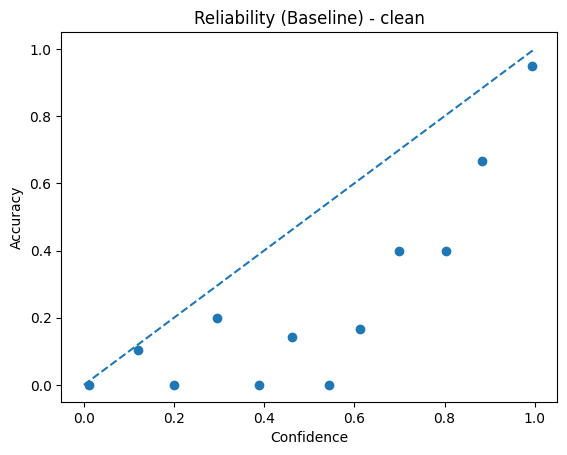

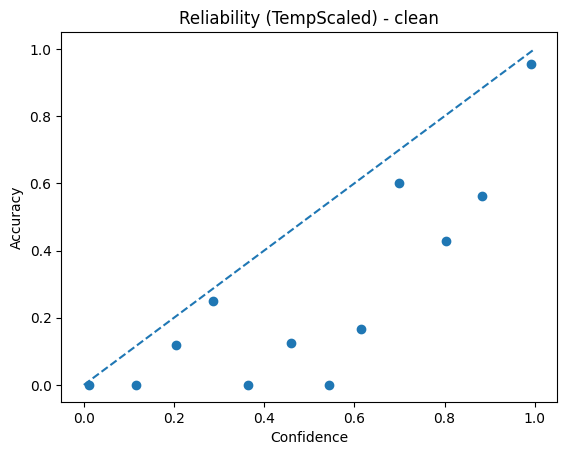

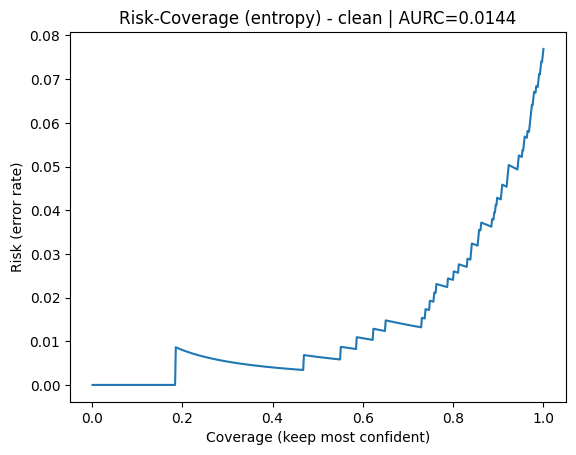


--- Condition: lowres_x4 ---

--- Condition: noise_s0.08 ---

--- Condition: jpeg_q30 ---

--- Condition: motion_k9 ---

--- Condition: gamma1.3_con1.15 ---

--- Condition: vign_s0.35 ---

--- Condition: crop_f0.10 ---

--- Condition: combined ---


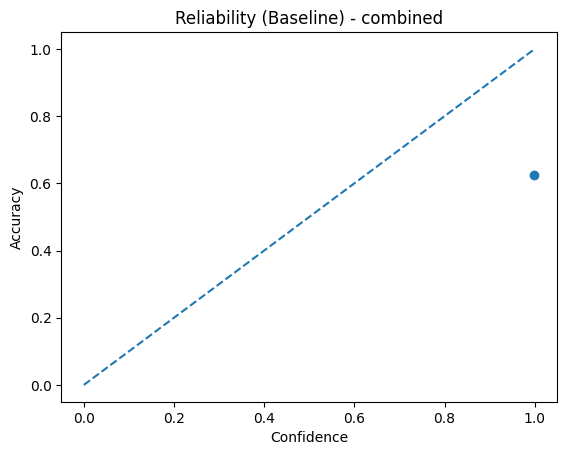

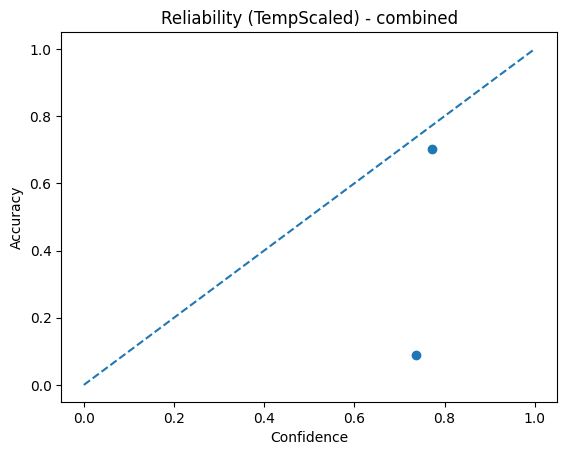

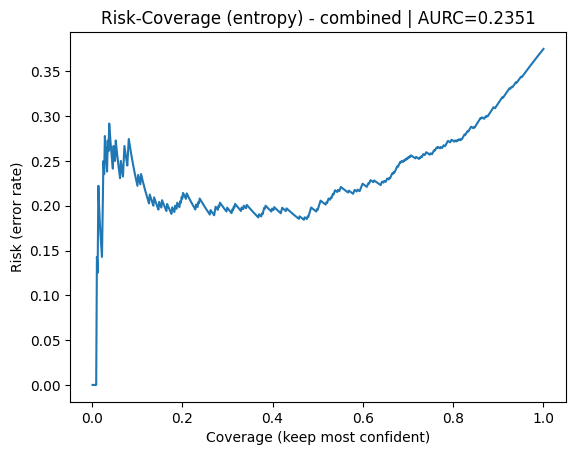


SEED: 43
Epoch 1/10 | train loss 0.1883 acc 0.924 auc 0.979 | val loss 0.1616 acc 0.948 auc 0.986
Epoch 2/10 | train loss 0.0654 acc 0.977 auc 0.996 | val loss 0.1063 acc 0.964 auc 0.991
Epoch 3/10 | train loss 0.0385 acc 0.985 auc 0.999 | val loss 0.1060 acc 0.956 auc 0.992
Epoch 4/10 | train loss 0.0246 acc 0.992 auc 1.000 | val loss 0.2086 acc 0.943 auc 0.996
Epoch 5/10 | train loss 0.0184 acc 0.993 auc 1.000 | val loss 0.1170 acc 0.966 auc 0.995
Epoch 6/10 | train loss 0.0249 acc 0.991 auc 1.000 | val loss 0.4392 acc 0.903 auc 0.993
Epoch 7/10 | train loss 0.0125 acc 0.996 auc 1.000 | val loss 0.1306 acc 0.964 auc 0.997
Epoch 8/10 | train loss 0.0065 acc 0.999 auc 1.000 | val loss 0.1635 acc 0.962 auc 0.996
Epoch 9/10 | train loss 0.0129 acc 0.996 auc 1.000 | val loss 0.1364 acc 0.964 auc 0.994
Epoch 10/10 | train loss 0.0142 acc 0.995 auc 1.000 | val loss 0.1114 acc 0.964 auc 0.996
Early stopping.
Loaded best val AUROC: 0.9974483847618103

--- Condition: clean ---

--- Condition:

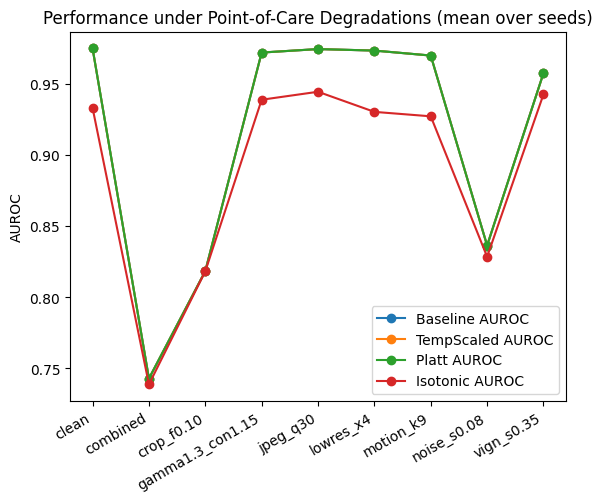

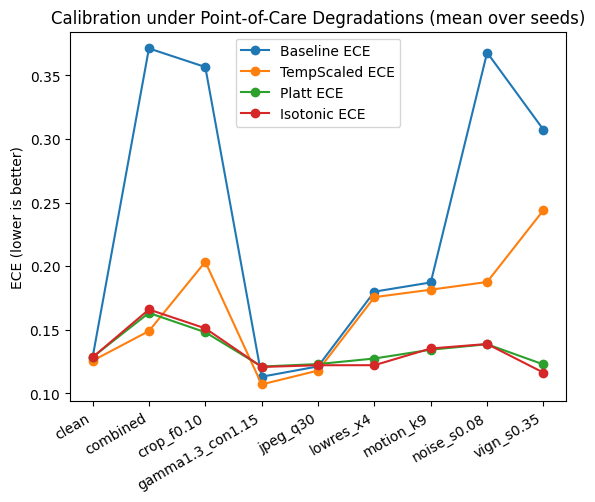

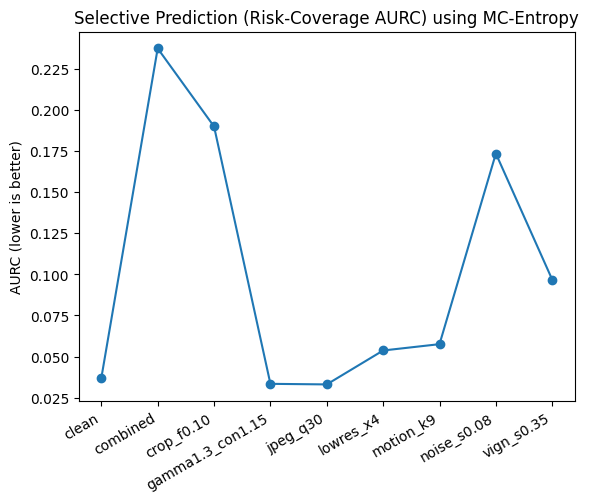


✅ Done. Outputs in: /content/miccai2026_poc_results_v2
Files: ['aggregate_metrics.csv', 'metrics_summary.json', 'per_seed_metrics.csv', 'plots']
Plots: ['aurc_across_conditions_mean.png', 'auroc_across_conditions_mean.png', 'ece_across_conditions_mean.png', 'reliability_baseline_clean.png', 'reliability_baseline_combined.png', 'reliability_tempscaled_clean.png', 'reliability_tempscaled_combined.png', 'risk_coverage_clean.png', 'risk_coverage_combined.png']


In [ ]:
# ====== MICCAI 2026 (IDEA1) One-Cell Colab Pipeline (Stronger Paper-Grade) ======
# End-to-end demo for: Trustworthy Point-of-Care Imaging under Resource Constraints
# Adds (vs your original):
#   - Multi-seed runs + mean/std + bootstrap CI
#   - More realistic degradations: motion blur, gamma/contrast, vignetting, crop/misalignment
#   - Degradation intensity sweeps (dose-response curves)
#   - Calibration baselines: Temperature Scaling, Platt (logistic), Isotonic
#   - Metrics: ACC, AUROC, ECE, NLL, Brier
#   - Selective prediction: Risk-Coverage + AURC
#   - Simple OOD detection AUROC (clean=ID, degraded=OOD) using entropy / maxprob
# Saves:
#   /content/miccai2026_poc_results_v2/
#     - per_seed_metrics.csv
#     - aggregate_metrics.csv
#     - metrics_summary.json
#     - plots/*.png

import os, math, random, time, json, warnings, io
warnings.filterwarnings("ignore")

# ---- (0) Install deps
!pip -q install medmnist torchmetrics tqdm pillow matplotlib pandas scikit-learn torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image, ImageEnhance

from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryCalibrationError
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score

# ---------------------------
# Utils
# ---------------------------
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

OUTDIR = "/content/miccai2026_poc_results_v2"
PLOTDIR = os.path.join(OUTDIR, "plots")
os.makedirs(PLOTDIR, exist_ok=True)

# Bootstrap CI for scalar metric
def bootstrap_ci(values, n_boot=2000, alpha=0.05, seed=0):
    rng = np.random.default_rng(seed)
    values = np.asarray(values, dtype=float)
    n = len(values)
    if n == 0:
        return (np.nan, np.nan)
    boots = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        boots.append(values[idx].mean())
    lo = np.quantile(boots, alpha/2)
    hi = np.quantile(boots, 1-alpha/2)
    return float(lo), float(hi)

# Negative log likelihood and Brier for probabilities
def nll_brier(probs, y):
    probs = np.clip(probs, 1e-6, 1-1e-6)
    y = y.astype(np.float32)
    nll = -(y*np.log(probs) + (1-y)*np.log(1-probs)).mean()
    brier = ((probs - y)**2).mean()
    return float(nll), float(brier)

# Risk-Coverage curve + AURC (lower is better)
def risk_coverage_auc(probs, y, uncertainty, threshold=0.5):
    """
    uncertainty: higher means more uncertain
    Sort by uncertainty ascending (most confident first).
    Compute risk at each coverage point.
    """
    probs = np.asarray(probs)
    y = np.asarray(y).astype(int)
    u = np.asarray(uncertainty)

    order = np.argsort(u)  # keep most confident first
    probs_s = probs[order]
    y_s = y[order]

    preds = (probs_s >= threshold).astype(int)
    errors = (preds != y_s).astype(float)

    n = len(y_s)
    coverages = np.arange(1, n+1) / n
    risks = np.cumsum(errors) / np.arange(1, n+1)

    # AURC via trapezoid
    aurc = np.trapz(risks, coverages)
    return coverages, risks, float(aurc)

# Reliability diagram
def reliability_plot(probs, y, n_bins=12, title="Reliability", savepath=None):
    probs = np.asarray(probs)
    y = np.asarray(y).astype(int)

    bins = np.linspace(0,1,n_bins+1)
    bin_ids = np.digitize(probs, bins) - 1
    bin_acc, bin_conf = [], []
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        bin_acc.append(y[mask].mean())
        bin_conf.append(probs[mask].mean())

    plt.figure()
    plt.plot([0,1],[0,1], linestyle="--")
    plt.scatter(bin_conf, bin_acc)
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    if savepath:
        plt.savefig(savepath, dpi=250, bbox_inches="tight")
    plt.show()

# ---------------------------
# (1) Dataset: MedMNIST PneumoniaMNIST (binary)
# ---------------------------
import medmnist
from medmnist import PneumoniaMNIST
from torchvision import transforms
from torchvision.models import resnet18

# MedMNIST images are 28x28 grayscale -> upscale to 224, repeat to 3ch
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Resize((224,224)),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Resize((224,224)),
])

train_set = PneumoniaMNIST(split="train", transform=train_tf, download=True)
val_set   = PneumoniaMNIST(split="val",   transform=test_tf,  download=True)
test_set  = PneumoniaMNIST(split="test",  transform=test_tf,  download=True)

print("Train/Val/Test:", len(train_set), len(val_set), len(test_set))

BATCH = 64
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# ---------------------------
# (2) Degradations (POC-like)
# ---------------------------
def degrade_lowres(x, factor=4):
    h, w = x.shape[-2], x.shape[-1]
    nh, nw = max(1, h//factor), max(1, w//factor)
    x_small = F.interpolate(x, size=(nh,nw), mode="bilinear", align_corners=False)
    x_back  = F.interpolate(x_small, size=(h,w), mode="bilinear", align_corners=False)
    return x_back

def degrade_noise(x, sigma=0.08):
    return torch.clamp(x + sigma*torch.randn_like(x), 0, 1)

def degrade_jpeg(x, quality=30):
    xs = []
    x_cpu = x.detach().cpu()
    for img in x_cpu:
        arr = (img.permute(1,2,0).numpy()*255).astype(np.uint8)
        pil = Image.fromarray(arr)
        buf = io.BytesIO()
        pil.save(buf, format="JPEG", quality=int(quality))
        buf.seek(0)
        pil2 = Image.open(buf).convert("RGB")
        arr2 = np.array(pil2).astype(np.float32)/255.0
        t = torch.from_numpy(arr2).permute(2,0,1)
        xs.append(t)
    return torch.stack(xs, dim=0).to(x.device)

def degrade_motion_blur(x, k=9):
    # Depthwise blur using separable kernel; k must be odd
    k = int(k)
    if k < 3: return x
    if k % 2 == 0: k += 1
    # 1D horizontal blur kernel (approx motion blur)
    kernel_1d = torch.ones(k, device=x.device, dtype=x.dtype) / k
    kernel = kernel_1d.view(1,1,1,k)  # horizontal
    # apply per-channel (depthwise)
    C = x.shape[1]
    kernel = kernel.repeat(C,1,1,1)
    x_pad = F.pad(x, (k//2, k//2, 0, 0), mode="reflect")
    return F.conv2d(x_pad, kernel, groups=C)

def degrade_gamma_contrast(x, gamma=1.2, contrast=1.1, brightness=1.0):
    # x in [0,1]
    y = torch.clamp(x, 0, 1)
    y = torch.clamp(y ** gamma, 0, 1)
    # contrast around 0.5
    y = torch.clamp((y - 0.5) * contrast + 0.5, 0, 1)
    y = torch.clamp(y * brightness, 0, 1)
    return y

def degrade_vignetting(x, strength=0.3):
    # multiplicative radial mask
    B, C, H, W = x.shape
    yy, xx = torch.meshgrid(torch.linspace(-1,1,H, device=x.device, dtype=x.dtype),
                            torch.linspace(-1,1,W, device=x.device, dtype=x.dtype),
                            indexing="ij")
    rr = torch.sqrt(xx**2 + yy**2)
    mask = 1.0 - strength * torch.clamp(rr, 0, 1)
    mask = mask.view(1,1,H,W)
    return torch.clamp(x * mask, 0, 1)

def degrade_crop_misalign(x, crop_frac=0.08):
    # crop edges then resize back
    B, C, H, W = x.shape
    dH = int(H * crop_frac)
    dW = int(W * crop_frac)
    if dH < 1 or dW < 1:
        return x
    y = x[:, :, dH:H-dH, dW:W-dW]
    y = F.interpolate(y, size=(H,W), mode="bilinear", align_corners=False)
    return y

def combined_degrade(x,
                     lowres_factor=4,
                     noise_sigma=0.06,
                     jpeg_quality=35,
                     blur_k=7,
                     gamma=1.15,
                     contrast=1.10,
                     vign_strength=0.25,
                     crop_frac=0.06):
    y = degrade_jpeg(x, quality=jpeg_quality)
    y = degrade_lowres(y, factor=lowres_factor)
    y = degrade_motion_blur(y, k=blur_k)
    y = degrade_gamma_contrast(y, gamma=gamma, contrast=contrast, brightness=1.0)
    y = degrade_vignetting(y, strength=vign_strength)
    y = degrade_crop_misalign(y, crop_frac=crop_frac)
    y = degrade_noise(y, sigma=noise_sigma)
    return y

# Define condition sets (including intensity sweeps)
CONDITIONS = [
    ("clean", lambda x: x),

    # single-strength (for headline)
    ("lowres_x4", lambda x: degrade_lowres(x, factor=4)),
    ("noise_s0.08", lambda x: degrade_noise(x, sigma=0.08)),
    ("jpeg_q30", lambda x: degrade_jpeg(x, quality=30)),
    ("motion_k9", lambda x: degrade_motion_blur(x, k=9)),
    ("gamma1.3_con1.15", lambda x: degrade_gamma_contrast(x, gamma=1.3, contrast=1.15, brightness=1.0)),
    ("vign_s0.35", lambda x: degrade_vignetting(x, strength=0.35)),
    ("crop_f0.10", lambda x: degrade_crop_misalign(x, crop_frac=0.10)),

    ("combined", lambda x: combined_degrade(x)),
]

# Optional: intensity sweeps (dose-response)
SWEEPS = {
    "noise": [0.02, 0.05, 0.08, 0.12],
    "lowres": [2, 4, 8],
    "jpeg": [10, 30, 50, 70],
    "blur": [3, 7, 11, 15],
}

def build_sweep_conditions():
    sweep_conds = []
    for sig in SWEEPS["noise"]:
        sweep_conds.append((f"noise_s{sig:.2f}", lambda x, s=sig: degrade_noise(x, sigma=s)))
    for f in SWEEPS["lowres"]:
        sweep_conds.append((f"lowres_x{f}", lambda x, ff=f: degrade_lowres(x, factor=ff)))
    for q in SWEEPS["jpeg"]:
        sweep_conds.append((f"jpeg_q{q}", lambda x, qq=q: degrade_jpeg(x, quality=qq)))
    for k in SWEEPS["blur"]:
        sweep_conds.append((f"blur_k{k}", lambda x, kk=k: degrade_motion_blur(x, k=kk)))
    return sweep_conds

SWEEP_CONDITIONS = build_sweep_conditions()

# ---------------------------
# (3) Model: ResNet18 + dropout head for MC-dropout
# ---------------------------
def build_model(seed=0):
    seed_all(seed)
    model = resnet18(weights="DEFAULT")
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.35),
        nn.Linear(in_features, 1)
    )
    return model.to(device)

# ---------------------------
# (4) Train / Predict / Metrics
# ---------------------------
ece_metric = BinaryCalibrationError(n_bins=15, norm="l1").to(device)

@torch.no_grad()
def predict_logits_probs(loader, degrade_fn, model):
    all_logits, all_probs, all_y = [], [], []
    model.eval()
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).int().view(-1)
        x = degrade_fn(x)
        logits = model(x).view(-1)
        probs = torch.sigmoid(logits)
        all_logits.append(logits.detach().cpu())
        all_probs.append(probs.detach().cpu())
        all_y.append(y.detach().cpu())
    return torch.cat(all_logits), torch.cat(all_probs), torch.cat(all_y)

def eval_metrics_cpu(probs_cpu, y_cpu):
    probs = probs_cpu.to(device)
    y = y_cpu.to(device).int()
    acc = BinaryAccuracy().to(device)(probs, y).item()
    auc = BinaryAUROC().to(device)(probs, y).item()
    ece = ece_metric(probs, y).item()
    probs_np = probs_cpu.numpy()
    y_np = y_cpu.numpy().astype(int)
    nll, brier = nll_brier(probs_np, y_np)
    return dict(acc=acc, auroc=auc, ece=ece, nll=nll, brier=brier)

def run_train(model, epochs=10, lr=2e-4, wd=1e-4, early_stop_patience=3):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.BCEWithLogitsLoss()

    best_val_auc = -1
    best_state = None
    no_improve = 0

    def epoch_pass(loader, train=True):
        model.train(train)
        loss_meter = 0.0
        n = 0
        auroc = BinaryAUROC().to(device)
        acc = BinaryAccuracy().to(device)
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).float().view(-1)
            logits = model(x).view(-1)
            loss = criterion(logits, y)

            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()

            with torch.no_grad():
                probs = torch.sigmoid(logits)
                auroc.update(probs, y.int())
                acc.update(probs, y.int())
                bs = x.size(0)
                loss_meter += loss.item() * bs
                n += bs
        return loss_meter/n, float(acc.compute().cpu()), float(auroc.compute().cpu())

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_auc = epoch_pass(train_loader, train=True)
        va_loss, va_acc, va_auc = epoch_pass(val_loader, train=False)
        print(f"Epoch {ep}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.3f} auc {tr_auc:.3f} "
              f"| val loss {va_loss:.4f} acc {va_acc:.3f} auc {va_auc:.3f}")

        if va_auc > best_val_auc + 1e-4:
            best_val_auc = va_auc
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_state)
    model.eval()
    return best_val_auc

# ---------------------------
# (5) Calibration Methods
# ---------------------------
class TemperatureScaler(nn.Module):
    def __init__(self, init_temp=1.5):
        super().__init__()
        self.log_t = nn.Parameter(torch.tensor([math.log(init_temp)], dtype=torch.float32))
    def forward(self, logits):
        t = torch.exp(self.log_t).clamp(1e-3, 100.0)
        return logits / t

def fit_temperature_from_logits(val_logits, val_y):
    # val_logits: CPU tensor, val_y: CPU tensor {0,1}
    scaler = TemperatureScaler(init_temp=1.5).to(device)
    optimizer = torch.optim.LBFGS(scaler.parameters(), lr=0.2, max_iter=50)

    logits = val_logits.to(device)
    y = val_y.to(device).float()

    def closure():
        optimizer.zero_grad()
        scaled = scaler(logits)
        loss = F.binary_cross_entropy_with_logits(scaled, y)
        loss.backward()
        return loss

    optimizer.step(closure)
    t = float(torch.exp(scaler.log_t).detach().cpu())
    return scaler, t

def apply_temperature(logits_cpu, scaler):
    logits = logits_cpu.to(device)
    with torch.no_grad():
        scaled = scaler(logits)
        probs = torch.sigmoid(scaled).detach().cpu()
    return probs

def fit_platt(val_logits, val_y):
    # Logistic regression on logit as 1D feature
    X = val_logits.numpy().reshape(-1, 1)
    y = val_y.numpy().astype(int)
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(X, y)
    return lr

def apply_platt(test_logits, lr_model):
    X = test_logits.numpy().reshape(-1, 1)
    p = lr_model.predict_proba(X)[:, 1]
    return torch.from_numpy(p.astype(np.float32))

def fit_isotonic(val_probs, val_y):
    x = val_probs.numpy().astype(np.float64)
    y = val_y.numpy().astype(int)
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(x, y)
    return iso

def apply_isotonic(test_probs, iso_model):
    x = test_probs.numpy().astype(np.float64)
    p = iso_model.predict(x)
    return torch.from_numpy(p.astype(np.float32))

# ---------------------------
# (6) MC Dropout uncertainty
# ---------------------------
def enable_dropout(model):
    for mod in model.modules():
        if isinstance(mod, nn.Dropout):
            mod.train()

@torch.no_grad()
def mc_dropout_mean_entropy(loader, degrade_fn, model, T=15):
    model.eval()
    enable_dropout(model)
    all_mean, all_ent, all_y = [], [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).int().view(-1)
        x = degrade_fn(x)
        probs_T = []
        for _ in range(T):
            logits = model(x).view(-1)
            probs_T.append(torch.sigmoid(logits))
        probs_T = torch.stack(probs_T, dim=0)  # T x B
        mean_p = probs_T.mean(dim=0)
        eps = 1e-6
        ent = -(mean_p*torch.log(mean_p+eps) + (1-mean_p)*torch.log(1-mean_p+eps))
        all_mean.append(mean_p.detach().cpu())
        all_ent.append(ent.detach().cpu())
        all_y.append(y.detach().cpu())
    return torch.cat(all_mean), torch.cat(all_ent), torch.cat(all_y)

# ---------------------------
# (7) OOD detection AUROC (clean=ID, degraded=OOD)
# ---------------------------
def ood_auroc(id_scores, ood_scores):
    # higher score => more OOD
    y = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))]).astype(int)
    s = np.concatenate([id_scores, ood_scores]).astype(float)
    return float(roc_auc_score(y, s))

# ---------------------------
# (8) Main experiment loop
# ---------------------------
SEEDS = [42, 43, 44, 45, 46]   # paper-grade
EPOCHS = 10
LR = 2e-4

all_rows = []
headline_conditions = CONDITIONS  # use these for main tables/plots

for seed in SEEDS:
    print("\n" + "="*80)
    print("SEED:", seed)
    seed_all(seed)

    model = build_model(seed=seed)
    best_val_auc = run_train(model, epochs=EPOCHS, lr=LR, wd=1e-4, early_stop_patience=3)
    print("Loaded best val AUROC:", best_val_auc)

    # Precompute clean ID uncertainty scores for OOD baseline
    clean_mean, clean_ent, clean_y = mc_dropout_mean_entropy(test_loader, lambda x: x, model, T=15)
    clean_maxprob = np.maximum(clean_mean.numpy(), 1 - clean_mean.numpy())
    clean_entropy = clean_ent.numpy()

    for cond_name, dfn in headline_conditions:
        print("\n--- Condition:", cond_name, "---")

        # Collect logits/probs on VAL for calibration fits under same condition
        val_logits, val_probs, val_y = predict_logits_probs(val_loader, dfn, model)

        # Collect logits/probs on TEST
        test_logits, test_probs, test_y = predict_logits_probs(test_loader, dfn, model)

        # Baseline metrics
        base = eval_metrics_cpu(test_probs, test_y)

        # Temperature scaling
        ts_scaler, temp = fit_temperature_from_logits(val_logits, val_y.float())
        ts_probs = apply_temperature(test_logits, ts_scaler)
        ts = eval_metrics_cpu(ts_probs, test_y)

        # Platt scaling
        platt = fit_platt(val_logits, val_y)
        platt_probs = apply_platt(test_logits, platt)
        pl = eval_metrics_cpu(platt_probs, test_y)

        # Isotonic on probabilities
        iso = fit_isotonic(val_probs, val_y)
        iso_probs = apply_isotonic(test_probs, iso)
        isom = eval_metrics_cpu(iso_probs, test_y)

        # Uncertainty (MC-dropout)
        mc_mean, mc_ent, mc_y = mc_dropout_mean_entropy(test_loader, dfn, model, T=15)
        mc_mean_np = mc_mean.numpy()
        mc_ent_np = mc_ent.numpy()
        mc_maxprob = np.maximum(mc_mean_np, 1 - mc_mean_np)

        # Selective prediction metrics (use entropy as uncertainty)
        cov, risk, aurc = risk_coverage_auc(test_probs.numpy(), test_y.numpy(), mc_ent_np, threshold=0.5)

        # OOD detection AUROC: ID=clean, OOD=this condition (skip clean itself)
        ood_auc_entropy = np.nan
        ood_auc_maxprob = np.nan
        if cond_name != "clean":
            ood_auc_entropy = ood_auroc(clean_entropy, mc_ent_np)
            # Convert maxprob to OOD score: lower maxprob => more OOD, so score = 1-maxprob
            ood_auc_maxprob = ood_auroc(1-clean_maxprob, 1-mc_maxprob)

        row = {
            "seed": seed,
            "condition": cond_name,

            # baseline
            "baseline_acc": base["acc"],
            "baseline_auroc": base["auroc"],
            "baseline_ece": base["ece"],
            "baseline_nll": base["nll"],
            "baseline_brier": base["brier"],

            # temperature scaling
            "temp": temp,
            "ts_acc": ts["acc"],
            "ts_auroc": ts["auroc"],
            "ts_ece": ts["ece"],
            "ts_nll": ts["nll"],
            "ts_brier": ts["brier"],

            # platt
            "platt_acc": pl["acc"],
            "platt_auroc": pl["auroc"],
            "platt_ece": pl["ece"],
            "platt_nll": pl["nll"],
            "platt_brier": pl["brier"],

            # isotonic
            "iso_acc": isom["acc"],
            "iso_auroc": isom["auroc"],
            "iso_ece": isom["ece"],
            "iso_nll": isom["nll"],
            "iso_brier": isom["brier"],

            # uncertainty / selective prediction
            "mc_entropy_mean": float(mc_ent_np.mean()),
            "mc_entropy_mean_incorrect": float(mc_ent_np[( (test_probs.numpy()>=0.5).astype(int) != test_y.numpy().astype(int) )].mean()) \
                if np.any((test_probs.numpy()>=0.5).astype(int) != test_y.numpy().astype(int)) else np.nan,
            "aurc_entropy": aurc,

            # OOD detection
            "ood_auroc_entropy": ood_auc_entropy,
            "ood_auroc_maxprob": ood_auc_maxprob,
        }
        all_rows.append(row)

        # Save a couple plots per seed (keep limited)
        if seed == SEEDS[0] and cond_name in ["clean", "combined"]:
            reliability_plot(test_probs.numpy(), test_y.numpy(), n_bins=12,
                             title=f"Reliability (Baseline) - {cond_name}",
                             savepath=os.path.join(PLOTDIR, f"reliability_baseline_{cond_name}.png"))
            reliability_plot(ts_probs.numpy(), test_y.numpy(), n_bins=12,
                             title=f"Reliability (TempScaled) - {cond_name}",
                             savepath=os.path.join(PLOTDIR, f"reliability_tempscaled_{cond_name}.png"))

            plt.figure()
            plt.plot(cov, risk)
            plt.xlabel("Coverage (keep most confident)")
            plt.ylabel("Risk (error rate)")
            plt.title(f"Risk-Coverage (entropy) - {cond_name} | AURC={aurc:.4f}")
            plt.savefig(os.path.join(PLOTDIR, f"risk_coverage_{cond_name}.png"), dpi=250, bbox_inches="tight")
            plt.show()

# ---------------------------
# (9) Aggregate + plots
# ---------------------------
df = pd.DataFrame(all_rows)
per_seed_csv = os.path.join(OUTDIR, "per_seed_metrics.csv")
df.to_csv(per_seed_csv, index=False)
print("Saved per-seed CSV:", per_seed_csv)

# Aggregate over seeds
agg = df.groupby("condition").agg(["mean","std"]).reset_index()
# Flatten columns
agg.columns = ["_".join([c for c in col if c]) for col in agg.columns.values]
agg_csv = os.path.join(OUTDIR, "aggregate_metrics.csv")
agg.to_csv(agg_csv, index=False)
print("Saved aggregate CSV:", agg_csv)

# Also build a compact JSON summary with CI for key metrics
summary = {}
for cond in sorted(df["condition"].unique()):
    d = df[df["condition"] == cond]
    summary[cond] = {}
    for key in ["baseline_auroc","baseline_ece","ts_ece","platt_ece","iso_ece","aurc_entropy","ood_auroc_entropy"]:
        vals = d[key].dropna().values.astype(float)
        summary[cond][key] = {
            "mean": float(np.mean(vals)) if len(vals) else float("nan"),
            "std": float(np.std(vals, ddof=1)) if len(vals) > 1 else float("nan"),
            "ci95": bootstrap_ci(vals, n_boot=2000, alpha=0.05, seed=0) if len(vals) else (float("nan"), float("nan"))
        }

json_path = os.path.join(OUTDIR, "metrics_summary.json")
with open(json_path, "w") as f:
    json.dump(summary, f, indent=2)
print("Saved JSON:", json_path)

# Plot: AUROC mean across conditions (baseline vs calibrated)
plot_df = df.groupby("condition")[["baseline_auroc","ts_auroc","platt_auroc","iso_auroc"]].mean().reset_index()
plt.figure()
plt.plot(plot_df["condition"], plot_df["baseline_auroc"], marker="o", label="Baseline AUROC")
plt.plot(plot_df["condition"], plot_df["ts_auroc"], marker="o", label="TempScaled AUROC")
plt.plot(plot_df["condition"], plot_df["platt_auroc"], marker="o", label="Platt AUROC")
plt.plot(plot_df["condition"], plot_df["iso_auroc"], marker="o", label="Isotonic AUROC")
plt.xticks(rotation=30, ha="right")
plt.ylabel("AUROC")
plt.title("Performance under Point-of-Care Degradations (mean over seeds)")
plt.legend()
plt.savefig(os.path.join(PLOTDIR, "auroc_across_conditions_mean.png"), dpi=250, bbox_inches="tight")
plt.show()

# Plot: ECE mean across conditions
plot_df2 = df.groupby("condition")[["baseline_ece","ts_ece","platt_ece","iso_ece"]].mean().reset_index()
plt.figure()
plt.plot(plot_df2["condition"], plot_df2["baseline_ece"], marker="o", label="Baseline ECE")
plt.plot(plot_df2["condition"], plot_df2["ts_ece"], marker="o", label="TempScaled ECE")
plt.plot(plot_df2["condition"], plot_df2["platt_ece"], marker="o", label="Platt ECE")
plt.plot(plot_df2["condition"], plot_df2["iso_ece"], marker="o", label="Isotonic ECE")
plt.xticks(rotation=30, ha="right")
plt.ylabel("ECE (lower is better)")
plt.title("Calibration under Point-of-Care Degradations (mean over seeds)")
plt.legend()
plt.savefig(os.path.join(PLOTDIR, "ece_across_conditions_mean.png"), dpi=250, bbox_inches="tight")
plt.show()

# Plot: AURC (selective prediction) mean across conditions
plot_df3 = df.groupby("condition")[["aurc_entropy"]].mean().reset_index()
plt.figure()
plt.plot(plot_df3["condition"], plot_df3["aurc_entropy"], marker="o")
plt.xticks(rotation=30, ha="right")
plt.ylabel("AURC (lower is better)")
plt.title("Selective Prediction (Risk-Coverage AURC) using MC-Entropy")
plt.savefig(os.path.join(PLOTDIR, "aurc_across_conditions_mean.png"), dpi=250, bbox_inches="tight")
plt.show()

print("\n✅ Done. Outputs in:", OUTDIR)
print("Files:", sorted(os.listdir(OUTDIR))[:30])
print("Plots:", sorted(os.listdir(PLOTDIR))[:30])


In [ ]:
import os, zipfile, shutil
from google.colab import files

src_dir = "/content/miccai2026_poc_results_v2"
zip_path = "/content/miccai2026_poc_results_v2.zip"

# clean old zip if exists
if os.path.exists(zip_path):
    os.remove(zip_path)

# zip folder
shutil.make_archive(zip_path.replace(".zip",""), "zip", src_dir)

print("Created:", zip_path)
files.download(zip_path)


Created: /content/miccai2026_poc_results_v2.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================
# MICCAI 2026 PoC Reliability — FULL ONE-CELL PIPELINE (Multi-backbone + extra PoC artifacts)
# ============================
import os, json, math, random, time, zipfile
from dataclasses import dataclass
from typing import Dict, List, Tuple, Callable

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18, resnet50, densenet121

from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt

# sklearn for calibration
!pip -q install scikit-learn medmnist
from sklearn.metrics import roc_auc_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

import medmnist
from medmnist import PneumoniaMNIST

# ----------------------------
# Config
# ----------------------------
@dataclass
class Cfg:
    out_dir: str = "/content/miccai2026_poc_results_v2"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    img_size: int = 224
    batch_size: int = 64
    num_workers: int = 2
    epochs: int = 2
    lr: float = 1e-3
    weight_decay: float = 1e-4
    seeds: Tuple[int, ...] = (42, 43, 44)
    backbones: Tuple[str, ...] = ("resnet18", "resnet50", "densenet121")  # <-- multi-backbone
    mc_samples: int = 20  # MC dropout passes for entropy
    ece_bins: int = 15

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)
fig_dir = os.path.join(cfg.out_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)

print("Device:", cfg.device)

# ----------------------------
# Utils
# ----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sigmoid_np(x):
    return 1.0 / (1.0 + np.exp(-x))

def ece_binary(probs: np.ndarray, y_true: np.ndarray, n_bins: int = 15) -> float:
    # probs: P(y=1)
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        conf = probs[mask].mean()
        acc = (y_true[mask] == (probs[mask] >= 0.5).astype(int)).mean()
        ece += (mask.sum() / len(probs)) * abs(acc - conf)
    return float(ece)

def reliability_points(probs: np.ndarray, y_true: np.ndarray, n_bins: int = 15):
    bins = np.linspace(0, 1, n_bins + 1)
    xs, ys, ns = [], [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        conf = probs[mask].mean()
        acc = (y_true[mask] == (probs[mask] >= 0.5).astype(int)).mean()
        xs.append(conf); ys.append(acc); ns.append(mask.sum())
    return np.array(xs), np.array(ys), np.array(ns)

def plot_reliability(probs: np.ndarray, y_true: np.ndarray, title: str, save_path: str, n_bins: int = 15):
    xs, ys, ns = reliability_points(probs, y_true, n_bins)
    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1],'--')
    plt.scatter(xs, ys)
    plt.xlabel("Confidence"); plt.ylabel("Accuracy")
    plt.title(title)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close()

def risk_coverage_curve(errors: np.ndarray, uncertainty: np.ndarray):
    """
    Sort by increasing uncertainty (most confident first).
    errors: 0/1 (1 means incorrect)
    uncertainty: higher => more uncertain
    returns coverage array and risk array
    """
    idx = np.argsort(uncertainty)  # confident first
    err_sorted = errors[idx]
    n = len(errors)
    risks = np.cumsum(err_sorted) / (np.arange(n) + 1)
    coverages = (np.arange(n) + 1) / n
    return coverages, risks

def aurc_from_rc(coverages: np.ndarray, risks: np.ndarray):
    # AURC = integral risk d(coverage) via trapezoid
    return float(np.trapz(risks, coverages))

def plot_risk_coverage(coverages, risks, title, save_path):
    plt.figure(figsize=(6,5))
    plt.plot(coverages, risks)
    plt.xlabel("Coverage (keep most confident)")
    plt.ylabel("Risk (error rate)")
    plt.title(title)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close()

# ----------------------------
# PoC corruptions (PIL-based)
# ----------------------------
def pil_to_tensor(img: Image.Image) -> torch.Tensor:
    return T.ToTensor()(img)

def tensor_to_pil(x: torch.Tensor) -> Image.Image:
    x = x.detach().cpu().clamp(0,1)
    return T.ToPILImage()(x)

def add_gaussian_noise(img: Image.Image, sigma: float = 0.08):
    arr = np.asarray(img).astype(np.float32)/255.0
    noise = np.random.normal(0, sigma, size=arr.shape).astype(np.float32)
    arr = np.clip(arr + noise, 0, 1)
    return Image.fromarray((arr*255).astype(np.uint8))

def lowres(img: Image.Image, factor: int = 4):
    w, h = img.size
    small = (max(1, w//factor), max(1, h//factor))
    img2 = img.resize(small, resample=Image.BILINEAR).resize((w,h), resample=Image.BILINEAR)
    return img2

def jpeg_compress(img: Image.Image, quality: int = 30):
    import io
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=quality)
    buf.seek(0)
    return Image.open(buf).convert("RGB")

def gamma_contrast(img: Image.Image, gamma: float = 1.3, contrast: float = 1.15):
    # gamma in PIL: approximate using power in float
    arr = np.asarray(img).astype(np.float32)/255.0
    arr = np.clip(arr, 1e-6, 1.0) ** gamma
    arr = np.clip(arr, 0, 1)
    img2 = Image.fromarray((arr*255).astype(np.uint8))
    img2 = ImageEnhance.Contrast(img2).enhance(contrast)
    return img2

def center_crop_fraction(img: Image.Image, frac: float = 0.10):
    # remove borders by cropping fraction from each side
    w, h = img.size
    dx, dy = int(w*frac), int(h*frac)
    cropped = img.crop((dx, dy, w-dx, h-dy))
    return cropped.resize((w,h), resample=Image.BILINEAR)

def motion_blur(img: Image.Image, k: int = 9):
    # simple horizontal motion blur kernel
    arr = np.asarray(img).astype(np.float32)
    kernel = np.zeros((k,k), dtype=np.float32)
    kernel[k//2, :] = 1.0 / k
    # apply via convolution per-channel
    import cv2
    out = cv2.filter2D(arr, -1, kernel)
    out = np.clip(out, 0, 255).astype(np.uint8)
    return Image.fromarray(out)

def vignette(img: Image.Image, strength: float = 0.35):
    arr = np.asarray(img).astype(np.float32)/255.0
    h, w = arr.shape[:2]
    y, x = np.ogrid[:h, :w]
    cy, cx = h/2, w/2
    dist = np.sqrt((x-cx)**2 + (y-cy)**2)
    dist = dist / dist.max()
    mask = 1.0 - strength*(dist**2)
    mask = np.clip(mask, 0, 1)
    arr2 = arr * mask[..., None]
    return Image.fromarray((np.clip(arr2,0,1)*255).astype(np.uint8))

# ---- NEW: defocus blur (clinical-ish)
def defocus_blur(img: Image.Image, radius: float = 2.0):
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

# ---- NEW: exposure / brightness clipping (clinical-ish)
def exposure_clip(img: Image.Image, gain: float = 1.4, clip_low: float = 0.0, clip_high: float = 1.0):
    arr = np.asarray(img).astype(np.float32)/255.0
    arr = arr * gain
    arr = np.clip(arr, clip_low, clip_high)  # clip highlights
    return Image.fromarray((arr*255).astype(np.uint8))

def combined(img: Image.Image):
    # Compose a few strong ones (tunable)
    img = lowres(img, 4)
    img = jpeg_compress(img, 30)
    img = motion_blur(img, 9)
    img = add_gaussian_noise(img, 0.08)
    img = vignette(img, 0.35)
    img = defocus_blur(img, 2.0)
    img = exposure_clip(img, 1.4)
    img = center_crop_fraction(img, 0.10)
    img = gamma_contrast(img, 1.3, 1.15)
    return img

# Condition registry (names match your paper figs style)
def make_conditions():
    return {
        "clean": lambda im: im,
        "jpeg_q30": lambda im: jpeg_compress(im, 30),
        "gamma1.3_con1.15": lambda im: gamma_contrast(im, 1.3, 1.15),
        "lowres_x4": lambda im: lowres(im, 4),
        "motion_k9": lambda im: motion_blur(im, 9),
        "vign_s0.35": lambda im: vignette(im, 0.35),
        "noise_s0.08": lambda im: add_gaussian_noise(im, 0.08),
        "crop_f0.10": lambda im: center_crop_fraction(im, 0.10),
        # NEW
        "defocus_r2": lambda im: defocus_blur(im, 2.0),
        "exposure_g1.4": lambda im: exposure_clip(im, 1.4),
        # combined
        "combined": lambda im: combined(im),
    }

CONDITIONS = make_conditions()

# ----------------------------
# Dataset (MedMNIST PneumoniaMNIST)
# ----------------------------
# Note: PneumoniaMNIST provides split sizes 4708/524/624 which matches your run
data_transform = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.ToTensor(),
])

# MedMNIST images are 28x28 RGB by default for PneumoniaMNIST (actually 1-channel but packed as RGB in PIL sometimes)
train_ds = PneumoniaMNIST(split='train', transform=data_transform, download=True)
val_ds   = PneumoniaMNIST(split='val',   transform=data_transform, download=True)
test_ds  = PneumoniaMNIST(split='test',  transform=data_transform, download=True)

print("Train/Val/Test:", len(train_ds), len(val_ds), len(test_ds))

def get_loader(ds, shuffle=False):
    return DataLoader(ds, batch_size=cfg.batch_size, shuffle=shuffle, num_workers=cfg.num_workers, pin_memory=True)

train_loader = get_loader(train_ds, shuffle=True)
val_loader   = get_loader(val_ds, shuffle=False)
test_loader_clean = get_loader(test_ds, shuffle=False)

# We'll re-wrap test set with corruption at evaluation time
class CorruptedWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, corruption_fn: Callable[[Image.Image], Image.Image], img_size: int):
        self.base_ds = base_ds
        self.corr = corruption_fn
        self.resize = T.Resize((img_size, img_size))
        self.to_tensor = T.ToTensor()

    def __len__(self): return len(self.base_ds)

    def __getitem__(self, idx):
        x, y = self.base_ds[idx]  # x is already tensor after transform; but we want PIL to corrupt
        # recover PIL
        pil = tensor_to_pil(x)
        pil = self.corr(pil)
        pil = self.resize(pil)
        x2 = self.to_tensor(pil)
        y2 = int(y[0]) if isinstance(y, np.ndarray) or (hasattr(y, "__len__") and len(y)>0) else int(y)
        return x2, y2

# ----------------------------
# Models
# ----------------------------
class BinaryHead(nn.Module):
    def __init__(self, in_dim: int, dropout: float = 0.2):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_dim, 1)

    def forward(self, x):
        x = self.dropout(x)
        return self.fc(x).squeeze(-1)

def build_model(name: str):
    if name == "resnet18":
        m = resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        in_dim = m.fc.in_features
        m.fc = BinaryHead(in_dim, dropout=0.2)
        return m
    if name == "resnet50":
        m = resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        in_dim = m.fc.in_features
        m.fc = BinaryHead(in_dim, dropout=0.2)
        return m
    if name == "densenet121":
        m = densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
        in_dim = m.classifier.in_features
        m.classifier = BinaryHead(in_dim, dropout=0.2)
        return m
    raise ValueError("Unknown backbone: " + name)

# ----------------------------
# Training / Inference
# ----------------------------
def train_one_seed(model, seed: int):
    set_seed(seed)
    model = model.to(cfg.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device=="cuda"))

    best_auc = -1.0
    best_state = None

    for ep in range(1, cfg.epochs+1):
        model.train()
        t0 = time.time()
        losses = []
        for xb, yb in train_loader:
            xb = xb.to(cfg.device)
            yb = yb.float().to(cfg.device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(cfg.device=="cuda")):
                logits = model(xb)
                loss = F.binary_cross_entropy_with_logits(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            losses.append(loss.item())

        # val
        model.eval()
        all_logits, all_y = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(cfg.device)
                logits = model(xb)
                all_logits.append(logits.detach().cpu().numpy())
                all_y.append(np.array(yb))
        all_logits = np.concatenate(all_logits)
        all_y = np.concatenate(all_y).astype(int)
        probs = sigmoid_np(all_logits)
        auc = roc_auc_score(all_y, probs)
        if auc > best_auc:
            best_auc = auc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        print(f"Epoch {ep}/{cfg.epochs} | train_loss={np.mean(losses):.4f} | val_auc={auc:.4f} | time={time.time()-t0:.1f}s")

    # load best
    model.load_state_dict(best_state)
    return model, best_auc

@torch.no_grad()
def predict_logits(model, loader):
    model.eval()
    logits_list, y_list = [], []
    for xb, yb in loader:
        xb = xb.to(cfg.device)
        logits = model(xb)
        logits_list.append(logits.detach().cpu().numpy())
        y_list.append(np.array(yb))
    return np.concatenate(logits_list), np.concatenate(y_list).astype(int)

def enable_dropout_only(m: nn.Module):
    # keep model in eval but enable dropout layers for MC sampling
    m.eval()
    for mod in m.modules():
        if isinstance(mod, nn.Dropout):
            mod.train()
    return m

@torch.no_grad()
def mc_entropy(model, loader, mc_samples: int = 20):
    model = enable_dropout_only(model)
    all_mean_probs, all_y = [], []
    for xb, yb in loader:
        xb = xb.to(cfg.device)
        probs_mc = []
        for _ in range(mc_samples):
            logits = model(xb)
            probs = torch.sigmoid(logits)
            probs_mc.append(probs.unsqueeze(0))
        probs_mc = torch.cat(probs_mc, dim=0)  # [M,B]
        mean_probs = probs_mc.mean(dim=0)      # [B]
        # binary entropy on mean prob
        p = mean_probs.clamp(1e-6, 1-1e-6)
        ent = -(p*torch.log(p) + (1-p)*torch.log(1-p))
        all_mean_probs.append(torch.stack([mean_probs.cpu(), ent.cpu()], dim=1).numpy())
        all_y.append(np.array(yb))
    arr = np.concatenate(all_mean_probs, axis=0)  # [N,2] mean_prob, entropy
    y = np.concatenate(all_y).astype(int)
    return arr[:,0], arr[:,1], y

# ----------------------------
# Post-hoc calibration (binary)
# ----------------------------
def temperature_scaling_fit(val_logits: np.ndarray, val_y: np.ndarray):
    # optimize scalar T to minimize NLL
    logits_t = torch.tensor(val_logits, dtype=torch.float32)
    y_t = torch.tensor(val_y, dtype=torch.float32)

    logT = torch.tensor(0.0, requires_grad=True)
    opt = torch.optim.LBFGS([logT], lr=0.1, max_iter=50)

    def closure():
        opt.zero_grad()
        Tval = torch.exp(logT)
        loss = F.binary_cross_entropy_with_logits(logits_t / Tval, y_t)
        loss.backward()
        return loss

    opt.step(closure)
    T_final = float(torch.exp(logT).detach().cpu())
    return T_final

def apply_temperature(logits: np.ndarray, Tval: float):
    return logits / Tval

def platt_fit(val_logits: np.ndarray, val_y: np.ndarray):
    # Logistic regression on logits -> calibrated prob
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(val_logits.reshape(-1,1), val_y)
    return lr

def platt_predict(lr_model, logits: np.ndarray):
    return lr_model.predict_proba(logits.reshape(-1,1))[:,1]

def iso_fit(val_probs: np.ndarray, val_y: np.ndarray):
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(val_probs, val_y)
    return iso

def iso_predict(iso_model, probs: np.ndarray):
    return iso_model.predict(probs)

# ----------------------------
# Run: multi-seed x multi-backbone x multi-condition
# ----------------------------
per_seed_rows = []
agg_rows = []

for backbone in cfg.backbones:
    print("\n==============================")
    print("Backbone:", backbone)
    print("==============================")

    for seed in cfg.seeds:
        print("\n--- Seed:", seed, "---")
        model = build_model(backbone)
        model, best_val_auc = train_one_seed(model, seed)

        # Fit calibrators on CLEAN val set
        val_logits, val_y = predict_logits(model, val_loader)
        val_probs = sigmoid_np(val_logits)

        Topt = temperature_scaling_fit(val_logits, val_y)
        platt = platt_fit(val_logits, val_y)
        iso = iso_fit(val_probs, val_y)

        # Evaluate each condition on TEST
        for cond_name, cond_fn in CONDITIONS.items():
            test_ds_cond = CorruptedWrapper(test_ds, cond_fn, cfg.img_size)
            test_loader = DataLoader(test_ds_cond, batch_size=cfg.batch_size, shuffle=False,
                                     num_workers=cfg.num_workers, pin_memory=True)

            logits, y = predict_logits(model, test_loader)
            probs_base = sigmoid_np(logits)

            # TS
            probs_ts = sigmoid_np(apply_temperature(logits, Topt))
            # Platt + Iso
            probs_platt = platt_predict(platt, logits)
            probs_iso = iso_predict(iso, probs_base)

            # AUROC
            auroc_base = roc_auc_score(y, probs_base)

            # ECE
            ece_base = ece_binary(probs_base, y, cfg.ece_bins)
            ece_ts   = ece_binary(probs_ts, y, cfg.ece_bins)
            ece_pl   = ece_binary(probs_platt, y, cfg.ece_bins)
            ece_iso  = ece_binary(probs_iso, y, cfg.ece_bins)

            # MC entropy + AURC
            mean_prob, ent, y_mc = mc_entropy(model, test_loader, cfg.mc_samples)
            pred = (mean_prob >= 0.5).astype(int)
            errors = (pred != y_mc).astype(int)
            cov, risk = risk_coverage_curve(errors, ent)
            aurc = aurc_from_rc(cov, risk)

            # OOD AUROC: entropy separates clean vs this condition (skip clean)
            ood_auc = np.nan
            if cond_name != "clean":
                # compute entropy on clean and this cond, then binary label
                clean_ds = CorruptedWrapper(test_ds, CONDITIONS["clean"], cfg.img_size)
                clean_loader = DataLoader(clean_ds, batch_size=cfg.batch_size, shuffle=False,
                                          num_workers=cfg.num_workers, pin_memory=True)
                _, ent_clean, _ = mc_entropy(model, clean_loader, cfg.mc_samples)
                ent_mix = np.concatenate([ent_clean, ent])
                lab_mix = np.concatenate([np.zeros_like(ent_clean), np.ones_like(ent)])
                try:
                    ood_auc = roc_auc_score(lab_mix, ent_mix)
                except:
                    ood_auc = np.nan

            per_seed_rows.append({
                "backbone": backbone,
                "seed": seed,
                "condition": cond_name,
                "val_best_auc": best_val_auc,
                "auroc_base": auroc_base,
                "ece_base": ece_base,
                "ece_ts": ece_ts,
                "ece_platt": ece_pl,
                "ece_iso": ece_iso,
                "aurc_entropy": aurc,
                "ood_auc_entropy": ood_auc,
            })

        # Save checkpoint per seed/backbone (optional)
        ckpt_path = os.path.join(cfg.out_dir, f"{backbone}_seed{seed}.pt")
        torch.save(model.state_dict(), ckpt_path)

# ----------------------------
# Aggregate mean±std over seeds (per backbone & condition)
# ----------------------------
df = pd.DataFrame(per_seed_rows)

def mean_std(x):
    return float(np.mean(x)), float(np.std(x, ddof=1)) if len(x)>1 else (float(np.mean(x)), 0.0)

agg = []
for backbone in cfg.backbones:
    for cond in CONDITIONS.keys():
        sub = df[(df.backbone==backbone) & (df.condition==cond)]
        row = {"backbone": backbone, "condition": cond}
        for col in ["auroc_base","ece_base","ece_ts","ece_platt","ece_iso","aurc_entropy","ood_auc_entropy"]:
            m, s = mean_std(sub[col].dropna().values)
            row[col+"_mean"] = m
            row[col+"_std"]  = s
        agg.append(row)

df_agg = pd.DataFrame(agg)

# Save CSV/JSON
per_seed_csv = os.path.join(cfg.out_dir, "per_seed_metrics.csv")
agg_csv = os.path.join(cfg.out_dir, "aggregate_metrics.csv")
df.to_csv(per_seed_csv, index=False)
df_agg.to_csv(agg_csv, index=False)

summary = {
    "config": cfg.__dict__,
    "notes": "Clean-train only; evaluate PoC corruptions; post-hoc TS/Platt/Iso; MC-entropy selective prediction.",
    "backbones": list(cfg.backbones),
    "conditions": list(CONDITIONS.keys()),
}
summary_path = os.path.join(cfg.out_dir, "metrics_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("Saved:", per_seed_csv)
print("Saved:", agg_csv)
print("Saved:", summary_path)

# ----------------------------
# Plotting helpers: mean curves (choose ONE backbone for paper plots)
# ----------------------------
PAPER_BACKBONE = "resnet18"  # change if you want resnet50/densenet121 for main paper
paper = df_agg[df_agg.backbone==PAPER_BACKBONE].copy()

# Keep consistent ordering
cond_order = list(CONDITIONS.keys())
paper["cond_idx"] = paper["condition"].apply(lambda x: cond_order.index(x))
paper = paper.sort_values("cond_idx")

def plot_metric_lines(paper_df, ycols, title, ylabel, save_name, legend_labels):
    plt.figure(figsize=(10,5))
    x = np.arange(len(paper_df))
    for ycol, lab in zip(ycols, legend_labels):
        plt.plot(x, paper_df[ycol].values, marker="o", label=lab)
    plt.xticks(x, paper_df["condition"].values, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(title + f" ({PAPER_BACKBONE}, mean over seeds)")
    plt.legend()
    plt.savefig(os.path.join(fig_dir, save_name), dpi=200, bbox_inches="tight")
    plt.close()

# AUROC across conditions (baseline only; calibrated AUROC usually similar)
plot_metric_lines(
    paper,
    ["auroc_base_mean"],
    "Performance under Point-of-Care Degradations",
    "AUROC",
    "auroc_across_conditions_mean.png",
    ["Baseline AUROC"]
)

# ECE across conditions
plot_metric_lines(
    paper,
    ["ece_base_mean","ece_ts_mean","ece_platt_mean","ece_iso_mean"],
    "Calibration under Point-of-Care Degradations",
    "ECE (lower is better)",
    "ece_across_conditions_mean.png",
    ["Baseline ECE","TempScaled ECE","Platt ECE","Isotonic ECE"]
)

# AURC across conditions
plot_metric_lines(
    paper,
    ["aurc_entropy_mean"],
    "Selective Prediction (Risk-Coverage AURC) using MC-Entropy",
    "AURC (lower is better)",
    "aurc_across_conditions_mean.png",
    ["Entropy AURC"]
)

# ----------------------------
# Reliability + Risk-Coverage example plots (clean vs combined; baseline vs TS)
# ----------------------------
def eval_and_plot_examples(backbone_for_example="resnet18", seed_for_example=42):
    # load trained model state (already saved)
    model = build_model(backbone_for_example).to(cfg.device)
    ckpt_path = os.path.join(cfg.out_dir, f"{backbone_for_example}_seed{seed_for_example}.pt")
    model.load_state_dict(torch.load(ckpt_path, map_location=cfg.device))
    model.eval()

    # fit TS from val
    val_logits, val_y = predict_logits(model, val_loader)
    Topt = temperature_scaling_fit(val_logits, val_y)

    for cond in ["clean","combined"]:
        test_ds_cond = CorruptedWrapper(test_ds, CONDITIONS[cond], cfg.img_size)
        test_loader = DataLoader(test_ds_cond, batch_size=cfg.batch_size, shuffle=False,
                                 num_workers=cfg.num_workers, pin_memory=True)
        logits, y = predict_logits(model, test_loader)
        probs_base = sigmoid_np(logits)
        probs_ts = sigmoid_np(apply_temperature(logits, Topt))

        plot_reliability(probs_base, y,
                         f"Reliability (Baseline) - {cond}",
                         os.path.join(fig_dir, f"reliability_baseline_{cond}.png"),
                         cfg.ece_bins)
        plot_reliability(probs_ts, y,
                         f"Reliability (TempScaled) - {cond}",
                         os.path.join(fig_dir, f"reliability_tempscaled_{cond}.png"),
                         cfg.ece_bins)

        # risk-coverage for entropy
        mean_prob, ent, y_mc = mc_entropy(model, test_loader, cfg.mc_samples)
        pred = (mean_prob >= 0.5).astype(int)
        errors = (pred != y_mc).astype(int)
        cov, risk = risk_coverage_curve(errors, ent)
        aurc = aurc_from_rc(cov, risk)
        plot_risk_coverage(cov, risk,
                           f"Risk-Coverage (entropy) - {cond} | AURC={aurc:.4f}",
                           os.path.join(fig_dir, f"risk_coverage_{cond}.png"))

eval_and_plot_examples(PAPER_BACKBONE, cfg.seeds[0])

# ----------------------------
# Zip everything for download
# ----------------------------
zip_path = os.path.join("/content", "miccai2026_poc_results_v2.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(cfg.out_dir):
        for fn in files:
            fp = os.path.join(root, fn)
            z.write(fp, arcname=os.path.relpath(fp, cfg.out_dir))

print("\n✅ Done.")
print("Outputs in:", cfg.out_dir)
print("Figures in:", fig_dir)
print("ZIP:", zip_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.8 MB/s eta 0:00:00
Device: cuda


100%|██████████| 4.17M/4.17M [00:06<00:00, 666kB/s]


Train/Val/Test: 4708 524 624

Backbone: resnet18

--- Seed: 42 ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]
/tmp/ipython-input-1671939490.py:328: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device=="cuda"))
/tmp/ipython-input-1671939490.py:341: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.device=="cuda")):


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [ ]:
# ============================
# 0) FIX BROKEN TORCH/TORCHVISION IN COLAB (torch has no _utils)
# ============================
!pip -q uninstall -y torch torchvision torchaudio torchtext || true
!pip -q cache purge || true

# Pick ONE of the following blocks. Block A is most common for Colab GPU.
# -------- Block A: CUDA 12.1 wheels (most Colab GPU images) --------
!pip -q install --upgrade pip
!pip -q install --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio

# If you are on CPU-only runtime, comment Block A and use Block B:
# -------- Block B: CPU wheels --------
# !pip -q install --index-url https://download.pytorch.org/whl/cpu torch torchvision torchaudio

import torch, torchvision
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("cuda available:", torch.cuda.is_available())

# ============================
# 1) NOW RUN YOUR FULL PIPELINE (PASTE THE WHOLE PIPELINE BELOW)
#    (keep your code exactly; after reinstall it should import torchvision fine)
# ============================

# --- paste your FULL ONE-CELL PIPELINE here ---


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.6 requires torch<2.10,>=1.10, which is not installed.
fastai 2.8.6 requires torchvision>=0.11, which is not installed.
torch: 2.9.0+cu126
torchvision: 0.24.0+cu126
cuda available: True


In [ ]:
# ============================
# MICCAI 2026 PoC Reliability — FULL ONE-CELL PIPELINE (FIXED 1ch->3ch + cv2 fallback + AMP warning fix)
# ============================
import os, json, math, random, time, zipfile
from dataclasses import dataclass
from typing import Dict, List, Tuple, Callable

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.models import resnet18, resnet50, densenet121

from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt

# sklearn for calibration
!pip -q install scikit-learn medmnist
from sklearn.metrics import roc_auc_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

import medmnist
from medmnist import PneumoniaMNIST

# ----------------------------
# Config
# ----------------------------
@dataclass
class Cfg:
    out_dir: str = "/content/miccai2026_poc_results_v2"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    img_size: int = 224
    batch_size: int = 64
    num_workers: int = 2
    epochs: int = 2
    lr: float = 1e-3
    weight_decay: float = 1e-4
    seeds: Tuple[int, ...] = (42, 43, 44)
    backbones: Tuple[str, ...] = ("resnet18", "resnet50", "densenet121")  # multi-backbone
    mc_samples: int = 20
    ece_bins: int = 15

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)
fig_dir = os.path.join(cfg.out_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)

print("Device:", cfg.device)

# ----------------------------
# Utils
# ----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sigmoid_np(x):
    return 1.0 / (1.0 + np.exp(-x))

def ece_binary(probs: np.ndarray, y_true: np.ndarray, n_bins: int = 15) -> float:
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        conf = probs[mask].mean()
        acc = (y_true[mask] == (probs[mask] >= 0.5).astype(int)).mean()
        ece += (mask.sum() / len(probs)) * abs(acc - conf)
    return float(ece)

def reliability_points(probs: np.ndarray, y_true: np.ndarray, n_bins: int = 15):
    bins = np.linspace(0, 1, n_bins + 1)
    xs, ys, ns = [], [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        conf = probs[mask].mean()
        acc = (y_true[mask] == (probs[mask] >= 0.5).astype(int)).mean()
        xs.append(conf); ys.append(acc); ns.append(mask.sum())
    return np.array(xs), np.array(ys), np.array(ns)

def plot_reliability(probs: np.ndarray, y_true: np.ndarray, title: str, save_path: str, n_bins: int = 15):
    xs, ys, ns = reliability_points(probs, y_true, n_bins)
    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1],'--')
    plt.scatter(xs, ys)
    plt.xlabel("Confidence"); plt.ylabel("Accuracy")
    plt.title(title)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close()

def risk_coverage_curve(errors: np.ndarray, uncertainty: np.ndarray):
    idx = np.argsort(uncertainty)  # confident first
    err_sorted = errors[idx]
    n = len(errors)
    risks = np.cumsum(err_sorted) / (np.arange(n) + 1)
    coverages = (np.arange(n) + 1) / n
    return coverages, risks

def aurc_from_rc(coverages: np.ndarray, risks: np.ndarray):
    return float(np.trapz(risks, coverages))

def plot_risk_coverage(coverages, risks, title, save_path):
    plt.figure(figsize=(6,5))
    plt.plot(coverages, risks)
    plt.xlabel("Coverage (keep most confident)")
    plt.ylabel("Risk (error rate)")
    plt.title(title)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close()

# ----------------------------
# PoC corruptions (PIL-based)
# ----------------------------
def pil_to_tensor(img: Image.Image) -> torch.Tensor:
    return T.ToTensor()(img)

def tensor_to_pil(x: torch.Tensor) -> Image.Image:
    x = x.detach().cpu().clamp(0,1)
    return T.ToPILImage()(x)

def add_gaussian_noise(img: Image.Image, sigma: float = 0.08):
    arr = np.asarray(img).astype(np.float32)/255.0
    noise = np.random.normal(0, sigma, size=arr.shape).astype(np.float32)
    arr = np.clip(arr + noise, 0, 1)
    return Image.fromarray((arr*255).astype(np.uint8))

def lowres(img: Image.Image, factor: int = 4):
    w, h = img.size
    small = (max(1, w//factor), max(1, h//factor))
    img2 = img.resize(small, resample=Image.BILINEAR).resize((w,h), resample=Image.BILINEAR)
    return img2

def jpeg_compress(img: Image.Image, quality: int = 30):
    import io
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=quality)
    buf.seek(0)
    return Image.open(buf).convert("RGB")

def gamma_contrast(img: Image.Image, gamma: float = 1.3, contrast: float = 1.15):
    arr = np.asarray(img).astype(np.float32)/255.0
    arr = np.clip(arr, 1e-6, 1.0) ** gamma
    arr = np.clip(arr, 0, 1)
    img2 = Image.fromarray((arr*255).astype(np.uint8))
    img2 = ImageEnhance.Contrast(img2).enhance(contrast)
    return img2

def center_crop_fraction(img: Image.Image, frac: float = 0.10):
    w, h = img.size
    dx, dy = int(w*frac), int(h*frac)
    cropped = img.crop((dx, dy, w-dx, h-dy))
    return cropped.resize((w,h), resample=Image.BILINEAR)

# ---- FIX: motion blur without hard dependency on cv2
def motion_blur(img: Image.Image, k: int = 9):
    try:
        import cv2
        arr = np.asarray(img).astype(np.float32)
        kernel = np.zeros((k,k), dtype=np.float32)
        kernel[k//2, :] = 1.0 / k
        out = cv2.filter2D(arr, -1, kernel)
        out = np.clip(out, 0, 255).astype(np.uint8)
        return Image.fromarray(out)
    except Exception:
        # fallback: approximate motion blur using PIL BoxBlur (not directional but stable)
        return img.filter(ImageFilter.BoxBlur(radius=max(1, k//3)))

def vignette(img: Image.Image, strength: float = 0.35):
    arr = np.asarray(img).astype(np.float32)/255.0
    h, w = arr.shape[:2]
    y, x = np.ogrid[:h, :w]
    cy, cx = h/2, w/2
    dist = np.sqrt((x-cx)**2 + (y-cy)**2)
    dist = dist / dist.max()
    mask = 1.0 - strength*(dist**2)
    mask = np.clip(mask, 0, 1)
    arr2 = arr * mask[..., None]
    return Image.fromarray((np.clip(arr2,0,1)*255).astype(np.uint8))

def defocus_blur(img: Image.Image, radius: float = 2.0):
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

def exposure_clip(img: Image.Image, gain: float = 1.4, clip_low: float = 0.0, clip_high: float = 1.0):
    arr = np.asarray(img).astype(np.float32)/255.0
    arr = arr * gain
    arr = np.clip(arr, clip_low, clip_high)
    return Image.fromarray((arr*255).astype(np.uint8))

def combined(img: Image.Image):
    img = lowres(img, 4)
    img = jpeg_compress(img, 30)
    img = motion_blur(img, 9)
    img = add_gaussian_noise(img, 0.08)
    img = vignette(img, 0.35)
    img = defocus_blur(img, 2.0)
    img = exposure_clip(img, 1.4)
    img = center_crop_fraction(img, 0.10)
    img = gamma_contrast(img, 1.3, 1.15)
    return img

def make_conditions():
    return {
        "clean": lambda im: im,
        "jpeg_q30": lambda im: jpeg_compress(im, 30),
        "gamma1.3_con1.15": lambda im: gamma_contrast(im, 1.3, 1.15),
        "lowres_x4": lambda im: lowres(im, 4),
        "motion_k9": lambda im: motion_blur(im, 9),
        "vign_s0.35": lambda im: vignette(im, 0.35),
        "noise_s0.08": lambda im: add_gaussian_noise(im, 0.08),
        "crop_f0.10": lambda im: center_crop_fraction(im, 0.10),
        "defocus_r2": lambda im: defocus_blur(im, 2.0),
        "exposure_g1.4": lambda im: exposure_clip(im, 1.4),
        "combined": lambda im: combined(im),
    }

CONDITIONS = make_conditions()

# ----------------------------
# Dataset (MedMNIST PneumoniaMNIST)  [FIX: 1ch->3ch]
# ----------------------------
data_transform = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1) if x.shape[0]==1 else x),  # FIX
])

train_ds = PneumoniaMNIST(split='train', transform=data_transform, download=True)
val_ds   = PneumoniaMNIST(split='val',   transform=data_transform, download=True)
test_ds  = PneumoniaMNIST(split='test',  transform=data_transform, download=True)

print("Train/Val/Test:", len(train_ds), len(val_ds), len(test_ds))

def get_loader(ds, shuffle=False):
    return DataLoader(ds, batch_size=cfg.batch_size, shuffle=shuffle, num_workers=cfg.num_workers, pin_memory=True)

train_loader = get_loader(train_ds, shuffle=True)
val_loader   = get_loader(val_ds, shuffle=False)
test_loader_clean = get_loader(test_ds, shuffle=False)

class CorruptedWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, corruption_fn: Callable[[Image.Image], Image.Image], img_size: int):
        self.base_ds = base_ds
        self.corr = corruption_fn
        self.resize = T.Resize((img_size, img_size))
        self.to_tensor = T.ToTensor()

    def __len__(self): return len(self.base_ds)

    def __getitem__(self, idx):
        x, y = self.base_ds[idx]  # x already 3ch tensor (after transform)
        pil = tensor_to_pil(x)
        pil = self.corr(pil)
        pil = self.resize(pil)
        x2 = self.to_tensor(pil)
        if x2.shape[0] == 1:  # FIX: corruption path may yield 1ch
            x2 = x2.repeat(3,1,1)
        y2 = int(y[0]) if isinstance(y, np.ndarray) or (hasattr(y, "__len__") and len(y)>0) else int(y)
        return x2, y2

# ----------------------------
# Models
# ----------------------------
class BinaryHead(nn.Module):
    def __init__(self, in_dim: int, dropout: float = 0.2):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_dim, 1)

    def forward(self, x):
        x = self.dropout(x)
        return self.fc(x).squeeze(-1)

def build_model(name: str):
    if name == "resnet18":
        m = resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        in_dim = m.fc.in_features
        m.fc = BinaryHead(in_dim, dropout=0.2)
        return m
    if name == "resnet50":
        m = resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        in_dim = m.fc.in_features
        m.fc = BinaryHead(in_dim, dropout=0.2)
        return m
    if name == "densenet121":
        m = densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
        in_dim = m.classifier.in_features
        m.classifier = BinaryHead(in_dim, dropout=0.2)
        return m
    raise ValueError("Unknown backbone: " + name)

# ----------------------------
# Training / Inference
# ----------------------------
def train_one_seed(model, seed: int):
    set_seed(seed)
    model = model.to(cfg.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    # FIX: new AMP API (removes FutureWarning)
    scaler = torch.amp.GradScaler('cuda', enabled=(cfg.device=="cuda"))

    best_auc = -1.0
    best_state = None

    for ep in range(1, cfg.epochs+1):
        model.train()
        t0 = time.time()
        losses = []
        for xb, yb in train_loader:
            xb = xb.to(cfg.device)
            yb = yb.float().to(cfg.device)
            opt.zero_grad(set_to_none=True)

            with torch.amp.autocast('cuda', enabled=(cfg.device=="cuda")):
                logits = model(xb)
                loss = F.binary_cross_entropy_with_logits(logits, yb)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            losses.append(loss.item())

        # val
        model.eval()
        all_logits, all_y = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(cfg.device)
                logits = model(xb)
                all_logits.append(logits.detach().cpu().numpy())
                all_y.append(np.array(yb))
        all_logits = np.concatenate(all_logits)
        all_y = np.concatenate(all_y).astype(int)
        probs = sigmoid_np(all_logits)
        auc = roc_auc_score(all_y, probs)
        if auc > best_auc:
            best_auc = auc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        print(f"Epoch {ep}/{cfg.epochs} | train_loss={np.mean(losses):.4f} | val_auc={auc:.4f} | time={time.time()-t0:.1f}s")

    model.load_state_dict(best_state)
    return model, best_auc

@torch.no_grad()
def predict_logits(model, loader):
    model.eval()
    logits_list, y_list = [], []
    for xb, yb in loader:
        xb = xb.to(cfg.device)
        logits = model(xb)
        logits_list.append(logits.detach().cpu().numpy())
        y_list.append(np.array(yb))
    return np.concatenate(logits_list), np.concatenate(y_list).astype(int)

def enable_dropout_only(m: nn.Module):
    m.eval()
    for mod in m.modules():
        if isinstance(mod, nn.Dropout):
            mod.train()
    return m

@torch.no_grad()
def mc_entropy(model, loader, mc_samples: int = 20):
    model = enable_dropout_only(model)
    all_mean_probs, all_y = [], []
    for xb, yb in loader:
        xb = xb.to(cfg.device)
        probs_mc = []
        for _ in range(mc_samples):
            logits = model(xb)
            probs = torch.sigmoid(logits)
            probs_mc.append(probs.unsqueeze(0))
        probs_mc = torch.cat(probs_mc, dim=0)  # [M,B]
        mean_probs = probs_mc.mean(dim=0)      # [B]
        p = mean_probs.clamp(1e-6, 1-1e-6)
        ent = -(p*torch.log(p) + (1-p)*torch.log(1-p))
        all_mean_probs.append(torch.stack([mean_probs.cpu(), ent.cpu()], dim=1).numpy())
        all_y.append(np.array(yb))
    arr = np.concatenate(all_mean_probs, axis=0)
    y = np.concatenate(all_y).astype(int)
    return arr[:,0], arr[:,1], y

# ----------------------------
# Post-hoc calibration (binary)
# ----------------------------
def temperature_scaling_fit(val_logits: np.ndarray, val_y: np.ndarray):
    logits_t = torch.tensor(val_logits, dtype=torch.float32)
    y_t = torch.tensor(val_y, dtype=torch.float32)

    logT = torch.tensor(0.0, requires_grad=True)
    opt = torch.optim.LBFGS([logT], lr=0.1, max_iter=50)

    def closure():
        opt.zero_grad()
        Tval = torch.exp(logT)
        loss = F.binary_cross_entropy_with_logits(logits_t / Tval, y_t)
        loss.backward()
        return loss

    opt.step(closure)
    T_final = float(torch.exp(logT).detach().cpu())
    return T_final

def apply_temperature(logits: np.ndarray, Tval: float):
    return logits / Tval

def platt_fit(val_logits: np.ndarray, val_y: np.ndarray):
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(val_logits.reshape(-1,1), val_y)
    return lr

def platt_predict(lr_model, logits: np.ndarray):
    return lr_model.predict_proba(logits.reshape(-1,1))[:,1]

def iso_fit(val_probs: np.ndarray, val_y: np.ndarray):
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(val_probs, val_y)
    return iso

def iso_predict(iso_model, probs: np.ndarray):
    return iso_model.predict(probs)

# ----------------------------
# Run: multi-seed x multi-backbone x multi-condition
# ----------------------------
per_seed_rows = []

for backbone in cfg.backbones:
    print("\n==============================")
    print("Backbone:", backbone)
    print("==============================")

    for seed in cfg.seeds:
        print("\n--- Seed:", seed, "---")
        model = build_model(backbone)
        model, best_val_auc = train_one_seed(model, seed)

        # Fit calibrators on CLEAN val set
        val_logits, val_y = predict_logits(model, val_loader)
        val_probs = sigmoid_np(val_logits)

        Topt = temperature_scaling_fit(val_logits, val_y)
        platt = platt_fit(val_logits, val_y)
        iso = iso_fit(val_probs, val_y)

        # cache clean entropy once per seed/backbone for OOD
        clean_ds_for_ood = CorruptedWrapper(test_ds, CONDITIONS["clean"], cfg.img_size)
        clean_loader_for_ood = DataLoader(clean_ds_for_ood, batch_size=cfg.batch_size, shuffle=False,
                                          num_workers=cfg.num_workers, pin_memory=True)
        _, ent_clean, _ = mc_entropy(model, clean_loader_for_ood, cfg.mc_samples)

        for cond_name, cond_fn in CONDITIONS.items():
            test_ds_cond = CorruptedWrapper(test_ds, cond_fn, cfg.img_size)
            test_loader = DataLoader(test_ds_cond, batch_size=cfg.batch_size, shuffle=False,
                                     num_workers=cfg.num_workers, pin_memory=True)

            logits, y = predict_logits(model, test_loader)
            probs_base = sigmoid_np(logits)

            probs_ts = sigmoid_np(apply_temperature(logits, Topt))
            probs_platt = platt_predict(platt, logits)
            probs_iso = iso_predict(iso, probs_base)

            auroc_base = roc_auc_score(y, probs_base)

            ece_base = ece_binary(probs_base, y, cfg.ece_bins)
            ece_ts   = ece_binary(probs_ts, y, cfg.ece_bins)
            ece_pl   = ece_binary(probs_platt, y, cfg.ece_bins)
            ece_iso  = ece_binary(probs_iso, y, cfg.ece_bins)

            mean_prob, ent, y_mc = mc_entropy(model, test_loader, cfg.mc_samples)
            pred = (mean_prob >= 0.5).astype(int)
            errors = (pred != y_mc).astype(int)
            cov, risk = risk_coverage_curve(errors, ent)
            aurc = aurc_from_rc(cov, risk)

            ood_auc = np.nan
            if cond_name != "clean":
                ent_mix = np.concatenate([ent_clean, ent])
                lab_mix = np.concatenate([np.zeros_like(ent_clean), np.ones_like(ent)])
                try:
                    ood_auc = roc_auc_score(lab_mix, ent_mix)
                except Exception:
                    ood_auc = np.nan

            per_seed_rows.append({
                "backbone": backbone,
                "seed": seed,
                "condition": cond_name,
                "val_best_auc": float(best_val_auc),
                "auroc_base": float(auroc_base),
                "ece_base": float(ece_base),
                "ece_ts": float(ece_ts),
                "ece_platt": float(ece_pl),
                "ece_iso": float(ece_iso),
                "aurc_entropy": float(aurc),
                "ood_auc_entropy": float(ood_auc) if not (isinstance(ood_auc, float) and np.isnan(ood_auc)) else np.nan,
            })

        ckpt_path = os.path.join(cfg.out_dir, f"{backbone}_seed{seed}.pt")
        torch.save(model.state_dict(), ckpt_path)

# ----------------------------
# Aggregate mean±std over seeds (per backbone & condition)
# ----------------------------
df = pd.DataFrame(per_seed_rows)

def mean_std(x):
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return (np.nan, np.nan)
    if len(x) == 1:
        return (float(x.mean()), 0.0)
    return (float(x.mean()), float(x.std(ddof=1)))

agg = []
for backbone in cfg.backbones:
    for cond in CONDITIONS.keys():
        sub = df[(df.backbone==backbone) & (df.condition==cond)]
        row = {"backbone": backbone, "condition": cond}
        for col in ["auroc_base","ece_base","ece_ts","ece_platt","ece_iso","aurc_entropy","ood_auc_entropy"]:
            m, s = mean_std(sub[col].values)
            row[col+"_mean"] = m
            row[col+"_std"]  = s
        agg.append(row)

df_agg = pd.DataFrame(agg)

per_seed_csv = os.path.join(cfg.out_dir, "per_seed_metrics.csv")
agg_csv = os.path.join(cfg.out_dir, "aggregate_metrics.csv")
df.to_csv(per_seed_csv, index=False)
df_agg.to_csv(agg_csv, index=False)

summary = {
    "config": cfg.__dict__,
    "notes": "Clean-train only; evaluate PoC corruptions; post-hoc TS/Platt/Iso; MC-entropy selective prediction.",
    "backbones": list(cfg.backbones),
    "conditions": list(CONDITIONS.keys()),
}
summary_path = os.path.join(cfg.out_dir, "metrics_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("Saved:", per_seed_csv)
print("Saved:", agg_csv)
print("Saved:", summary_path)

# ----------------------------
# Plotting helpers: mean curves (choose ONE backbone for paper plots)
# ----------------------------
PAPER_BACKBONE = "resnet18"
paper = df_agg[df_agg.backbone==PAPER_BACKBONE].copy()

cond_order = list(CONDITIONS.keys())
paper["cond_idx"] = paper["condition"].apply(lambda x: cond_order.index(x))
paper = paper.sort_values("cond_idx")

def plot_metric_lines(paper_df, ycols, title, ylabel, save_name, legend_labels):
    plt.figure(figsize=(10,5))
    x = np.arange(len(paper_df))
    for ycol, lab in zip(ycols, legend_labels):
        plt.plot(x, paper_df[ycol].values, marker="o", label=lab)
    plt.xticks(x, paper_df["condition"].values, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(title + f" ({PAPER_BACKBONE}, mean over seeds)")
    plt.legend()
    plt.savefig(os.path.join(fig_dir, save_name), dpi=200, bbox_inches="tight")
    plt.close()

plot_metric_lines(
    paper,
    ["auroc_base_mean"],
    "Performance under Point-of-Care Degradations",
    "AUROC",
    "auroc_across_conditions_mean.png",
    ["Baseline AUROC"]
)

plot_metric_lines(
    paper,
    ["ece_base_mean","ece_ts_mean","ece_platt_mean","ece_iso_mean"],
    "Calibration under Point-of-Care Degradations",
    "ECE (lower is better)",
    "ece_across_conditions_mean.png",
    ["Baseline ECE","TempScaled ECE","Platt ECE","Isotonic ECE"]
)

plot_metric_lines(
    paper,
    ["aurc_entropy_mean"],
    "Selective Prediction (Risk-Coverage AURC) using MC-Entropy",
    "AURC (lower is better)",
    "aurc_across_conditions_mean.png",
    ["Entropy AURC"]
)

# ----------------------------
# Reliability + Risk-Coverage example plots (clean vs combined; baseline vs TS)
# ----------------------------
def eval_and_plot_examples(backbone_for_example="resnet18", seed_for_example=42):
    model = build_model(backbone_for_example).to(cfg.device)
    ckpt_path = os.path.join(cfg.out_dir, f"{backbone_for_example}_seed{seed_for_example}.pt")
    model.load_state_dict(torch.load(ckpt_path, map_location=cfg.device))
    model.eval()

    val_logits, val_y = predict_logits(model, val_loader)
    Topt = temperature_scaling_fit(val_logits, val_y)

    for cond in ["clean","combined"]:
        test_ds_cond = CorruptedWrapper(test_ds, CONDITIONS[cond], cfg.img_size)
        test_loader = DataLoader(test_ds_cond, batch_size=cfg.batch_size, shuffle=False,
                                 num_workers=cfg.num_workers, pin_memory=True)
        logits, y = predict_logits(model, test_loader)
        probs_base = sigmoid_np(logits)
        probs_ts = sigmoid_np(apply_temperature(logits, Topt))

        plot_reliability(probs_base, y,
                         f"Reliability (Baseline) - {cond}",
                         os.path.join(fig_dir, f"reliability_baseline_{cond}.png"),
                         cfg.ece_bins)
        plot_reliability(probs_ts, y,
                         f"Reliability (TempScaled) - {cond}",
                         os.path.join(fig_dir, f"reliability_tempscaled_{cond}.png"),
                         cfg.ece_bins)

        mean_prob, ent, y_mc = mc_entropy(model, test_loader, cfg.mc_samples)
        pred = (mean_prob >= 0.5).astype(int)
        errors = (pred != y_mc).astype(int)
        cov, risk = risk_coverage_curve(errors, ent)
        aurc = aurc_from_rc(cov, risk)
        plot_risk_coverage(cov, risk,
                           f"Risk-Coverage (entropy) - {cond} | AURC={aurc:.4f}",
                           os.path.join(fig_dir, f"risk_coverage_{cond}.png"))

eval_and_plot_examples(PAPER_BACKBONE, cfg.seeds[0])

# ----------------------------
# Zip everything for download
# ----------------------------
zip_path = os.path.join("/content", "miccai2026_poc_results_v2.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(cfg.out_dir):
        for fn in files:
            fp = os.path.join(root, fn)
            z.write(fp, arcname=os.path.relpath(fp, cfg.out_dir))

print("\n✅ Done.")
print("Outputs in:", cfg.out_dir)
print("Figures in:", fig_dir)
print("ZIP:", zip_path)

Device: cuda
Train/Val/Test: 4708 524 624

Backbone: resnet18

--- Seed: 42 ---


ValueError: Target size (torch.Size([64, 1])) must be the same as input size (torch.Size([64]))

In [ ]:
# ============================
# MICCAI 2026 PoC Reliability — FULL ONE-CELL PIPELINE (COLAB GPU FINAL)
#  - FIX environment: reinstall torch/torchvision GPU wheels (cu121)
#  - FIX 1ch->3ch
#  - FIX cv2 fallback for motion blur
#  - FIX AMP (new API)
#  - FIX BCE logits/targets shape ([B] vs [B,1])
# ============================

import os, sys, json, random, time, zipfile, subprocess

def run(cmd):
    print(">", cmd)
    subprocess.check_call(cmd, shell=True)

# ----------------------------
# 0) ENV FIX (Colab GPU): reinstall a consistent CUDA build
# ----------------------------
def torch_is_ok():
    try:
        import torch
        import torch._utils
        return True
    except Exception as e:
        print("torch check failed:", repr(e))
        return False

def ensure_colab_gpu_stack():
    # Make sure GPU runtime is enabled in Colab: Runtime -> Change runtime type -> GPU
    # Then install a consistent torch/torchvision/torchaudio CUDA stack (cu121 is most stable).
    run(f"{sys.executable} -m pip uninstall -y torch torchvision torchaudio || true")
    run(f"{sys.executable} -m pip cache purge || true")
    run(
        f"{sys.executable} -m pip install -q --no-cache-dir "
        f"--index-url https://download.pytorch.org/whl/cu121 "
        f"torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1"
    )

if not torch_is_ok():
    print("\n[ENV] Broken torch detected. Installing Colab GPU (cu121) stack...\n")
    ensure_colab_gpu_stack()

# Re-import and verify
import torch
assert hasattr(torch, "_utils") or __import__("torch._utils"), "Torch still broken. In Colab, please Runtime -> Restart runtime, then re-run this cell."
print("✅ torch:", torch.__version__)

import torchvision
print("✅ torchvision:", torchvision.__version__)

# GPU check (must be True in Colab GPU runtime)
print("CUDA available:", torch.cuda.is_available())
if not torch.cuda.is_available():
    print("⚠️ CUDA not available. In Colab, set Runtime -> Change runtime type -> GPU, then re-run.")

# ----------------------------
# 1) Imports (pipeline)
# ----------------------------
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.models import resnet18, resnet50, densenet121

from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt

# deps
run(f"{sys.executable} -m pip install -q --upgrade --no-cache-dir scikit-learn medmnist")
from sklearn.metrics import roc_auc_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

import medmnist
from medmnist import PneumoniaMNIST

# ----------------------------
# 2) Config
# ----------------------------
from dataclasses import dataclass
from typing import Tuple, Callable

@dataclass
class Cfg:
    out_dir: str = "/content/miccai2026_poc_results_v2"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    img_size: int = 224
    batch_size: int = 64
    num_workers: int = 2
    epochs: int = 2
    lr: float = 1e-3
    weight_decay: float = 1e-4
    seeds: Tuple[int, ...] = (42, 43, 44)
    backbones: Tuple[str, ...] = ("resnet18", "resnet50", "densenet121")
    mc_samples: int = 20
    ece_bins: int = 15

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)
fig_dir = os.path.join(cfg.out_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)

print("Device:", cfg.device)

# ----------------------------
# 3) Utils
# ----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sigmoid_np(x):
    x = np.asarray(x).reshape(-1)
    return 1.0 / (1.0 + np.exp(-x))

def ece_binary(probs: np.ndarray, y_true: np.ndarray, n_bins: int = 15) -> float:
    probs = np.asarray(probs).reshape(-1)
    y_true = np.asarray(y_true).reshape(-1).astype(int)
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        conf = probs[mask].mean()
        acc = (y_true[mask] == (probs[mask] >= 0.5).astype(int)).mean()
        ece += (mask.sum() / len(probs)) * abs(acc - conf)
    return float(ece)

def reliability_points(probs: np.ndarray, y_true: np.ndarray, n_bins: int = 15):
    probs = np.asarray(probs).reshape(-1)
    y_true = np.asarray(y_true).reshape(-1).astype(int)
    bins = np.linspace(0, 1, n_bins + 1)
    xs, ys, ns = [], [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi) if i < n_bins-1 else (probs >= lo) & (probs <= hi)
        if mask.sum() == 0:
            continue
        conf = probs[mask].mean()
        acc = (y_true[mask] == (probs[mask] >= 0.5).astype(int)).mean()
        xs.append(conf); ys.append(acc); ns.append(mask.sum())
    return np.array(xs), np.array(ys), np.array(ns)

def plot_reliability(probs: np.ndarray, y_true: np.ndarray, title: str, save_path: str, n_bins: int = 15):
    xs, ys, _ = reliability_points(probs, y_true, n_bins)
    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1],'--')
    plt.scatter(xs, ys)
    plt.xlabel("Confidence"); plt.ylabel("Accuracy")
    plt.title(title)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close()

def risk_coverage_curve(errors: np.ndarray, uncertainty: np.ndarray):
    errors = np.asarray(errors).reshape(-1).astype(int)
    uncertainty = np.asarray(uncertainty).reshape(-1).astype(float)
    idx = np.argsort(uncertainty)  # confident first
    err_sorted = errors[idx]
    n = len(errors)
    risks = np.cumsum(err_sorted) / (np.arange(n) + 1)
    coverages = (np.arange(n) + 1) / n
    return coverages, risks

def aurc_from_rc(coverages: np.ndarray, risks: np.ndarray):
    return float(np.trapz(risks, coverages))

def plot_risk_coverage(coverages, risks, title, save_path):
    plt.figure(figsize=(6,5))
    plt.plot(coverages, risks)
    plt.xlabel("Coverage (keep most confident)")
    plt.ylabel("Risk (error rate)")
    plt.title(title)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close()

# ----------------------------
# 4) PoC corruptions (PIL)
# ----------------------------
def tensor_to_pil(x: torch.Tensor) -> Image.Image:
    x = x.detach().cpu().clamp(0,1)
    return T.ToPILImage()(x)

def add_gaussian_noise(img: Image.Image, sigma: float = 0.08):
    arr = np.asarray(img).astype(np.float32)/255.0
    noise = np.random.normal(0, sigma, size=arr.shape).astype(np.float32)
    arr = np.clip(arr + noise, 0, 1)
    return Image.fromarray((arr*255).astype(np.uint8))

def lowres(img: Image.Image, factor: int = 4):
    w, h = img.size
    small = (max(1, w//factor), max(1, h//factor))
    return img.resize(small, resample=Image.BILINEAR).resize((w,h), resample=Image.BILINEAR)

def jpeg_compress(img: Image.Image, quality: int = 30):
    import io
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=quality)
    buf.seek(0)
    return Image.open(buf).convert("RGB")

def gamma_contrast(img: Image.Image, gamma: float = 1.3, contrast: float = 1.15):
    arr = np.asarray(img).astype(np.float32)/255.0
    arr = np.clip(arr, 1e-6, 1.0) ** gamma
    arr = np.clip(arr, 0, 1)
    img2 = Image.fromarray((arr*255).astype(np.uint8))
    return ImageEnhance.Contrast(img2).enhance(contrast)

def center_crop_fraction(img: Image.Image, frac: float = 0.10):
    w, h = img.size
    dx, dy = int(w*frac), int(h*frac)
    cropped = img.crop((dx, dy, w-dx, h-dy))
    return cropped.resize((w,h), resample=Image.BILINEAR)

def motion_blur(img: Image.Image, k: int = 9):
    try:
        import cv2
        arr = np.asarray(img).astype(np.float32)
        kernel = np.zeros((k,k), dtype=np.float32)
        kernel[k//2, :] = 1.0 / k
        out = cv2.filter2D(arr, -1, kernel)
        out = np.clip(out, 0, 255).astype(np.uint8)
        return Image.fromarray(out)
    except Exception:
        return img.filter(ImageFilter.BoxBlur(radius=max(1, k//3)))

def vignette(img: Image.Image, strength: float = 0.35):
    arr = np.asarray(img).astype(np.float32)/255.0
    h, w = arr.shape[:2]
    y, x = np.ogrid[:h, :w]
    cy, cx = h/2, w/2
    dist = np.sqrt((x-cx)**2 + (y-cy)**2)
    dist = dist / dist.max()
    mask = 1.0 - strength*(dist**2)
    mask = np.clip(mask, 0, 1)
    arr2 = arr * mask[..., None]
    return Image.fromarray((np.clip(arr2,0,1)*255).astype(np.uint8))

def defocus_blur(img: Image.Image, radius: float = 2.0):
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

def exposure_clip(img: Image.Image, gain: float = 1.4, clip_low: float = 0.0, clip_high: float = 1.0):
    arr = np.asarray(img).astype(np.float32)/255.0
    arr = np.clip(arr * gain, clip_low, clip_high)
    return Image.fromarray((arr*255).astype(np.uint8))

def combined(img: Image.Image):
    img = lowres(img, 4)
    img = jpeg_compress(img, 30)
    img = motion_blur(img, 9)
    img = add_gaussian_noise(img, 0.08)
    img = vignette(img, 0.35)
    img = defocus_blur(img, 2.0)
    img = exposure_clip(img, 1.4)
    img = center_crop_fraction(img, 0.10)
    img = gamma_contrast(img, 1.3, 1.15)
    return img

def make_conditions():
    return {
        "clean": lambda im: im,
        "jpeg_q30": lambda im: jpeg_compress(im, 30),
        "gamma1.3_con1.15": lambda im: gamma_contrast(im, 1.3, 1.15),
        "lowres_x4": lambda im: lowres(im, 4),
        "motion_k9": lambda im: motion_blur(im, 9),
        "vign_s0.35": lambda im: vignette(im, 0.35),
        "noise_s0.08": lambda im: add_gaussian_noise(im, 0.08),
        "crop_f0.10": lambda im: center_crop_fraction(im, 0.10),
        "defocus_r2": lambda im: defocus_blur(im, 2.0),
        "exposure_g1.4": lambda im: exposure_clip(im, 1.4),
        "combined": lambda im: combined(im),
    }

CONDITIONS = make_conditions()

# ----------------------------
# 5) Dataset (1ch->3ch)
# ----------------------------
data_transform = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1) if x.shape[0]==1 else x),
])

train_ds = PneumoniaMNIST(split='train', transform=data_transform, download=True)
val_ds   = PneumoniaMNIST(split='val',   transform=data_transform, download=True)
test_ds  = PneumoniaMNIST(split='test',  transform=data_transform, download=True)
print("Train/Val/Test:", len(train_ds), len(val_ds), len(test_ds))

def get_loader(ds, shuffle=False):
    return DataLoader(ds, batch_size=cfg.batch_size, shuffle=shuffle,
                      num_workers=cfg.num_workers, pin_memory=True)

train_loader = get_loader(train_ds, shuffle=True)
val_loader   = get_loader(val_ds, shuffle=False)

class CorruptedWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, corruption_fn: Callable[[Image.Image], Image.Image], img_size: int):
        self.base_ds = base_ds
        self.corr = corruption_fn
        self.resize = T.Resize((img_size, img_size))
        self.to_tensor = T.ToTensor()

    def __len__(self): return len(self.base_ds)

    def __getitem__(self, idx):
        x, y = self.base_ds[idx]
        pil = tensor_to_pil(x)
        pil = self.corr(pil)
        pil = self.resize(pil)
        x2 = self.to_tensor(pil)
        if x2.shape[0] == 1:
            x2 = x2.repeat(3,1,1)
        y2 = int(np.array(y).reshape(-1)[0])
        return x2, y2

# ----------------------------
# 6) Models
# ----------------------------
class BinaryHead(nn.Module):
    def __init__(self, in_dim: int, dropout: float = 0.2):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_dim, 1)
    def forward(self, x):
        return self.fc(self.dropout(x)).squeeze(-1)

def build_model(name: str):
    if name == "resnet18":
        m = resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        m.fc = BinaryHead(m.fc.in_features, dropout=0.2)
        return m
    if name == "resnet50":
        m = resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        m.fc = BinaryHead(m.fc.in_features, dropout=0.2)
        return m
    if name == "densenet121":
        m = densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
        m.classifier = BinaryHead(m.classifier.in_features, dropout=0.2)
        return m
    raise ValueError("Unknown backbone: " + name)

# ----------------------------
# 7) Train / Predict / MC entropy
# ----------------------------
def train_one_seed(model, seed: int):
    set_seed(seed)
    model = model.to(cfg.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    use_cuda = (cfg.device == "cuda")
    scaler = torch.amp.GradScaler('cuda', enabled=use_cuda)

    best_auc = -1.0
    best_state = None

    for ep in range(1, cfg.epochs+1):
        model.train()
        t0 = time.time()
        losses = []
        for xb, yb in train_loader:
            xb = xb.to(cfg.device)
            yb = yb.float().to(cfg.device).view(-1)
            opt.zero_grad(set_to_none=True)

            with torch.amp.autocast('cuda', enabled=use_cuda):
                logits = model(xb).view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, yb)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            losses.append(loss.item())

        model.eval()
        all_logits, all_y = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(cfg.device)
                logits = model(xb).view(-1)
                all_logits.append(logits.detach().cpu().numpy())
                all_y.append(np.array(yb).reshape(-1))
        all_logits = np.concatenate(all_logits)
        all_y = np.concatenate(all_y).astype(int)
        auc = roc_auc_score(all_y, sigmoid_np(all_logits))

        if auc > best_auc:
            best_auc = auc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}

        print(f"Epoch {ep}/{cfg.epochs} | train_loss={np.mean(losses):.4f} | val_auc={auc:.4f} | time={time.time()-t0:.1f}s")

    model.load_state_dict(best_state)
    return model, best_auc

@torch.no_grad()
def predict_logits(model, loader):
    model.eval()
    logits_list, y_list = [], []
    for xb, yb in loader:
        xb = xb.to(cfg.device)
        logits = model(xb).view(-1)
        logits_list.append(logits.detach().cpu().numpy())
        y_list.append(np.array(yb).reshape(-1))
    return np.concatenate(logits_list), np.concatenate(y_list).astype(int)

def enable_dropout_only(m: nn.Module):
    m.eval()
    for mod in m.modules():
        if isinstance(mod, nn.Dropout):
            mod.train()
    return m

@torch.no_grad()
def mc_entropy(model, loader, mc_samples: int = 20):
    model = enable_dropout_only(model)
    all_mean_probs, all_y = [], []
    for xb, yb in loader:
        xb = xb.to(cfg.device)
        yb_np = np.array(yb).reshape(-1)
        probs_mc = []
        for _ in range(mc_samples):
            logits = model(xb).view(-1)
            probs_mc.append(torch.sigmoid(logits).unsqueeze(0))
        probs_mc = torch.cat(probs_mc, dim=0)
        mean_probs = probs_mc.mean(dim=0)
        p = mean_probs.clamp(1e-6, 1-1e-6)
        ent = -(p*torch.log(p) + (1-p)*torch.log(1-p))
        all_mean_probs.append(torch.stack([mean_probs.cpu(), ent.cpu()], dim=1).numpy())
        all_y.append(yb_np)
    arr = np.concatenate(all_mean_probs, axis=0)
    y = np.concatenate(all_y).astype(int)
    return arr[:,0], arr[:,1], y

# ----------------------------
# 8) Calibration
# ----------------------------
def temperature_scaling_fit(val_logits: np.ndarray, val_y: np.ndarray):
    val_logits = np.asarray(val_logits).reshape(-1)
    val_y = np.asarray(val_y).reshape(-1).astype(float)

    logits_t = torch.tensor(val_logits, dtype=torch.float32)
    y_t = torch.tensor(val_y, dtype=torch.float32)

    logT = torch.tensor(0.0, requires_grad=True)
    opt = torch.optim.LBFGS([logT], lr=0.1, max_iter=50)

    def closure():
        opt.zero_grad()
        Tval = torch.exp(logT)
        loss = F.binary_cross_entropy_with_logits(logits_t / Tval, y_t)
        loss.backward()
        return loss

    opt.step(closure)
    return float(torch.exp(logT).detach().cpu())

def apply_temperature(logits: np.ndarray, Tval: float):
    return np.asarray(logits).reshape(-1) / Tval

def platt_fit(val_logits: np.ndarray, val_y: np.ndarray):
    lr = LogisticRegression(solver="lbfgs", max_iter=1000)
    lr.fit(np.asarray(val_logits).reshape(-1,1), np.asarray(val_y).reshape(-1).astype(int))
    return lr

def platt_predict(lr_model, logits: np.ndarray):
    return lr_model.predict_proba(np.asarray(logits).reshape(-1,1))[:,1]

def iso_fit(val_probs: np.ndarray, val_y: np.ndarray):
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(np.asarray(val_probs).reshape(-1), np.asarray(val_y).reshape(-1).astype(int))
    return iso

def iso_predict(iso_model, probs: np.ndarray):
    return iso_model.predict(np.asarray(probs).reshape(-1))

# ----------------------------
# 9) Run: multi-seed x multi-backbone x multi-condition
# ----------------------------
per_seed_rows = []

for backbone in cfg.backbones:
    print("\n==============================")
    print("Backbone:", backbone)
    print("==============================")

    for seed in cfg.seeds:
        print("\n--- Seed:", seed, "---")
        model = build_model(backbone)
        model, best_val_auc = train_one_seed(model, seed)

        val_logits, val_y = predict_logits(model, val_loader)
        val_probs = sigmoid_np(val_logits)

        Topt  = temperature_scaling_fit(val_logits, val_y)
        platt = platt_fit(val_logits, val_y)
        iso   = iso_fit(val_probs, val_y)

        clean_ds_for_ood = CorruptedWrapper(test_ds, CONDITIONS["clean"], cfg.img_size)
        clean_loader_for_ood = DataLoader(clean_ds_for_ood, batch_size=cfg.batch_size, shuffle=False,
                                          num_workers=cfg.num_workers, pin_memory=True)
        _, ent_clean, _ = mc_entropy(model, clean_loader_for_ood, cfg.mc_samples)

        for cond_name, cond_fn in CONDITIONS.items():
            test_ds_cond = CorruptedWrapper(test_ds, cond_fn, cfg.img_size)
            test_loader = DataLoader(test_ds_cond, batch_size=cfg.batch_size, shuffle=False,
                                     num_workers=cfg.num_workers, pin_memory=True)

            logits, y = predict_logits(model, test_loader)
            probs_base = sigmoid_np(logits)
            probs_ts    = sigmoid_np(apply_temperature(logits, Topt))
            probs_platt = platt_predict(platt, logits)
            probs_iso   = iso_predict(iso, probs_base)

            auroc_base = roc_auc_score(y, probs_base)

            ece_base = ece_binary(probs_base,  y, cfg.ece_bins)
            ece_ts   = ece_binary(probs_ts,    y, cfg.ece_bins)
            ece_pl   = ece_binary(probs_platt, y, cfg.ece_bins)
            ece_iso  = ece_binary(probs_iso,   y, cfg.ece_bins)

            mean_prob, ent, y_mc = mc_entropy(model, test_loader, cfg.mc_samples)
            pred = (mean_prob >= 0.5).astype(int)
            errors = (pred != y_mc).astype(int)
            cov, risk = risk_coverage_curve(errors, ent)
            aurc = aurc_from_rc(cov, risk)

            ood_auc = np.nan
            if cond_name != "clean":
                ent_mix = np.concatenate([ent_clean, ent])
                lab_mix = np.concatenate([np.zeros_like(ent_clean), np.ones_like(ent)])
                try:
                    ood_auc = roc_auc_score(lab_mix, ent_mix)
                except Exception:
                    ood_auc = np.nan

            per_seed_rows.append({
                "backbone": backbone,
                "seed": seed,
                "condition": cond_name,
                "val_best_auc": float(best_val_auc),
                "auroc_base": float(auroc_base),
                "ece_base": float(ece_base),
                "ece_ts": float(ece_ts),
                "ece_platt": float(ece_pl),
                "ece_iso": float(ece_iso),
                "aurc_entropy": float(aurc),
                "ood_auc_entropy": float(ood_auc) if not (isinstance(ood_auc, float) and np.isnan(ood_auc)) else np.nan,
            })

        ckpt_path = os.path.join(cfg.out_dir, f"{backbone}_seed{seed}.pt")
        torch.save(model.state_dict(), ckpt_path)

# ----------------------------
# 10) Aggregate + save
# ----------------------------
df = pd.DataFrame(per_seed_rows)

def mean_std(x):
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0: return (np.nan, np.nan)
    if len(x) == 1: return (float(x.mean()), 0.0)
    return (float(x.mean()), float(x.std(ddof=1)))

agg = []
for backbone in cfg.backbones:
    for cond in CONDITIONS.keys():
        sub = df[(df.backbone==backbone) & (df.condition==cond)]
        row = {"backbone": backbone, "condition": cond}
        for col in ["auroc_base","ece_base","ece_ts","ece_platt","ece_iso","aurc_entropy","ood_auc_entropy"]:
            m, s = mean_std(sub[col].values)
            row[col+"_mean"] = m
            row[col+"_std"]  = s
        agg.append(row)

df_agg = pd.DataFrame(agg)

per_seed_csv = os.path.join(cfg.out_dir, "per_seed_metrics.csv")
agg_csv      = os.path.join(cfg.out_dir, "aggregate_metrics.csv")
df.to_csv(per_seed_csv, index=False)
df_agg.to_csv(agg_csv, index=False)

summary = {
    "config": cfg.__dict__,
    "notes": "Clean-train only; evaluate PoC corruptions; post-hoc TS/Platt/Iso; MC-entropy selective prediction.",
    "backbones": list(cfg.backbones),
    "conditions": list(CONDITIONS.keys()),
}
summary_path = os.path.join(cfg.out_dir, "metrics_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("Saved:", per_seed_csv)
print("Saved:", agg_csv)
print("Saved:", summary_path)

# ----------------------------
# 11) Plots (paper backbone)
# ----------------------------
PAPER_BACKBONE = "resnet18"
paper = df_agg[df_agg.backbone==PAPER_BACKBONE].copy()
cond_order = list(CONDITIONS.keys())
paper["cond_idx"] = paper["condition"].apply(lambda x: cond_order.index(x))
paper = paper.sort_values("cond_idx")

def plot_metric_lines(paper_df, ycols, title, ylabel, save_name, legend_labels):
    plt.figure(figsize=(10,5))
    x = np.arange(len(paper_df))
    for ycol, lab in zip(ycols, legend_labels):
        plt.plot(x, paper_df[ycol].values, marker="o", label=lab)
    plt.xticks(x, paper_df["condition"].values, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(title + f" ({PAPER_BACKBONE}, mean over seeds)")
    plt.legend()
    plt.savefig(os.path.join(fig_dir, save_name), dpi=200, bbox_inches="tight")
    plt.close()

plot_metric_lines(paper, ["auroc_base_mean"],
                  "Performance under Point-of-Care Degradations",
                  "AUROC", "auroc_across_conditions_mean.png",
                  ["Baseline AUROC"])

plot_metric_lines(paper, ["ece_base_mean","ece_ts_mean","ece_platt_mean","ece_iso_mean"],
                  "Calibration under Point-of-Care Degradations",
                  "ECE (lower is better)", "ece_across_conditions_mean.png",
                  ["Baseline ECE","TempScaled ECE","Platt ECE","Isotonic ECE"])

plot_metric_lines(paper, ["aurc_entropy_mean"],
                  "Selective Prediction (Risk-Coverage AURC) using MC-Entropy",
                  "AURC (lower is better)", "aurc_across_conditions_mean.png",
                  ["Entropy AURC"])

# Example plots
def eval_and_plot_examples(backbone_for_example="resnet18", seed_for_example=42):
    model = build_model(backbone_for_example).to(cfg.device)
    ckpt_path = os.path.join(cfg.out_dir, f"{backbone_for_example}_seed{seed_for_example}.pt")
    model.load_state_dict(torch.load(ckpt_path, map_location=cfg.device))
    model.eval()

    val_logits, val_y = predict_logits(model, val_loader)
    Topt = temperature_scaling_fit(val_logits, val_y)

    for cond in ["clean","combined"]:
        test_ds_cond = CorruptedWrapper(test_ds, CONDITIONS[cond], cfg.img_size)
        test_loader = DataLoader(test_ds_cond, batch_size=cfg.batch_size, shuffle=False,
                                 num_workers=cfg.num_workers, pin_memory=True)
        logits, y = predict_logits(model, test_loader)
        probs_base = sigmoid_np(logits)
        probs_ts = sigmoid_np(apply_temperature(logits, Topt))

        plot_reliability(probs_base, y,
                         f"Reliability (Baseline) - {cond}",
                         os.path.join(fig_dir, f"reliability_baseline_{cond}.png"),
                         cfg.ece_bins)
        plot_reliability(probs_ts, y,
                         f"Reliability (TempScaled) - {cond}",
                         os.path.join(fig_dir, f"reliability_tempscaled_{cond}.png"),
                         cfg.ece_bins)

        mean_prob, ent, y_mc = mc_entropy(model, test_loader, cfg.mc_samples)
        pred = (mean_prob >= 0.5).astype(int)
        errors = (pred != y_mc).astype(int)
        cov, risk = risk_coverage_curve(errors, ent)
        aurc = aurc_from_rc(cov, risk)
        plot_risk_coverage(cov, risk,
                           f"Risk-Coverage (entropy) - {cond} | AURC={aurc:.4f}",
                           os.path.join(fig_dir, f"risk_coverage_{cond}.png"))

eval_and_plot_examples(PAPER_BACKBONE, cfg.seeds[0])

# ----------------------------
# 12) Zip
# ----------------------------
zip_path = os.path.join("/content", "miccai2026_poc_results_v2.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(cfg.out_dir):
        for fn in files:
            fp = os.path.join(root, fn)
            z.write(fp, arcname=os.path.relpath(fp, cfg.out_dir))

print("\n✅ Done.")
print("Outputs in:", cfg.out_dir)
print("Figures in:", fig_dir)
print("ZIP:", zip_path)


✅ torch: 2.9.0+cu126
✅ torchvision: 0.24.0+cu126
CUDA available: True
> /usr/bin/python3 -m pip install -q --upgrade --no-cache-dir scikit-learn medmnist
Device: cuda


100%|██████████| 4.17M/4.17M [00:04<00:00, 953kB/s]


Train/Val/Test: 4708 524 624

Backbone: resnet18

--- Seed: 42 ---
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 245MB/s]


Epoch 1/2 | train_loss=0.1632 | val_auc=0.9948 | time=9.5s
Epoch 2/2 | train_loss=0.0856 | val_auc=0.9975 | time=7.8s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in


--- Seed: 43 ---
Epoch 1/2 | train_loss=0.1697 | val_auc=0.9930 | time=8.0s
Epoch 2/2 | train_loss=0.0951 | val_auc=0.9962 | time=7.6s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in


--- Seed: 44 ---
Epoch 1/2 | train_loss=0.1866 | val_auc=0.9921 | time=8.0s
Epoch 2/2 | train_loss=0.0776 | val_auc=0.9947 | time=7.7s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in


Backbone: resnet50

--- Seed: 42 ---
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]


Epoch 1/2 | train_loss=0.1942 | val_auc=0.9861 | time=20.3s
Epoch 2/2 | train_loss=0.0862 | val_auc=0.9832 | time=20.0s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in


--- Seed: 43 ---
Epoch 1/2 | train_loss=0.1798 | val_auc=0.9933 | time=20.0s
Epoch 2/2 | train_loss=0.1075 | val_auc=0.9923 | time=19.9s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in


--- Seed: 44 ---
Epoch 1/2 | train_loss=0.1865 | val_auc=0.9850 | time=20.0s
Epoch 2/2 | train_loss=0.0904 | val_auc=0.9793 | time=19.9s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in


Backbone: densenet121

--- Seed: 42 ---
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 200MB/s]


Epoch 1/2 | train_loss=0.1577 | val_auc=0.9914 | time=24.5s
Epoch 2/2 | train_loss=0.0928 | val_auc=0.9945 | time=23.7s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in


--- Seed: 43 ---
Epoch 1/2 | train_loss=0.1832 | val_auc=0.9904 | time=23.8s
Epoch 2/2 | train_loss=0.1019 | val_auc=0.9888 | time=23.6s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in


--- Seed: 44 ---
Epoch 1/2 | train_loss=0.1752 | val_auc=0.9903 | time=23.6s
Epoch 2/2 | train_loss=0.0899 | val_auc=0.9932 | time=23.6s


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))
/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in

Saved: /content/miccai2026_poc_results_v2/per_seed_metrics.csv
Saved: /content/miccai2026_poc_results_v2/aggregate_metrics.csv
Saved: /content/miccai2026_poc_results_v2/metrics_summary.json


/tmp/ipython-input-1644646602.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(risks, coverages))



✅ Done.
Outputs in: /content/miccai2026_poc_results_v2
Figures in: /content/miccai2026_poc_results_v2/figures
ZIP: /content/miccai2026_poc_results_v2.zip


In [ ]:
from google.colab import files

files.download("/content/miccai2026_poc_results_v2.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>